## 1. Primero, necesitamos entender nuestra estructura de datos

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que tu dataframe tiene esta estructura
# (Ajusta según tus variables reales)
def crear_estructura_ejemplo():
    data = {
        # Character
        'puntaje_credito': [750, 680, 820, 600, 710],
        'antiguedad_credito': [5, 2, 10, 1, 4],
        'historial_pagos': [1, 0, 1, 0, 1],  # 1=bueno, 0=malo
        
        # Capacity
        'ingreso_mensual': [5000, 3000, 8000, 2500, 4000],
        'dti': [0.25, 0.45, 0.15, 0.60, 0.35],
        'deuda_total': [10000, 15000, 5000, 20000, 12000],
        
        # Capital
        'ahorros': [20000, 5000, 50000, 1000, 15000],
        'inversiones': [15000, 2000, 100000, 500, 8000],
        'patrimonio_neto': [50000, 10000, 200000, 2000, 30000],
        
        # Collateral
        'valor_garantia': [30000, 15000, 80000, 8000, 25000],
        'ltv': [0.70, 0.85, 0.50, 0.95, 0.75],
        
        # Conditions
        'estabilidad_empleo': [3, 1, 5, 1, 2],  # años en el trabajo
        'sector_trabajo': ['servicios', 'construccion', 'tech', 'retail', 'salud'],
        
        # Variable objetivo (lo que quieres predecir)
        'incumplio': [0, 1, 0, 1, 0]  # 0=no incumplió, 1=incumplió
    }
    return pd.DataFrame(data)

def LeerBaseDatos():
    # === 1. Cargar datos ===
    ruta = "./../Registros_sin_nulos.csv"
    df = pd.read_csv(ruta)

    # === 2. Crear variable target ===
    df["target"] = df["diasmora"].apply(lambda x: 1 if x > 7 else 0)

    # Eliminar columnas que no se usarán
    df = df.drop(columns=["nosocio", "nocredito", "sucursal", "diasmora"], errors="ignore")

    return df
#df = crear_estructura_ejemplo()
df = LeerBaseDatos()
print("Estructura de datos de ejemplo:")
print(df.head())

Estructura de datos de ejemplo:
  clasificacion                        producto    monto  tasaordinaria  \
0       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  20000.0           30.0   
1       CONSUMO          CREDI-PROMOCION LACHAO  15000.0           30.0   
2       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA   5000.0           30.0   
3       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  10000.0           30.0   
4       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  10000.0           30.0   

   tasamoratoria plazocredito  frecuenciacapint renovadoestructurado  \
0           60.0     18 MESES                30               NORMAL   
1           60.0     12 MESES                30               NORMAL   
2           60.0     12 MESES                30               NORMAL   
3           60.0     12 MESES                30               NORMAL   
4           60.0     12 MESES                30               NORMAL   

  vigentevencido  montogarantialiq  ...                                deudas  \
0  

## 2. Cálculo del Peso de cada C usando Machine Learning

In [2]:
def calcular_pesos_5c(df, variable_objetivo='target'):
    """
    Calcula la importancia de cada una de las 5 C's usando Random Forest
    """
    # Mapear variables a cada C
    variables_por_c = {
        "Carácter": ["reputación_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        "Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        "Colateral": ["solidario", "pro_comunal", "pro_privada","lÍquida"]
    }
    
    # Preparar datos
    X = df.drop(columns=[variable_objetivo])
    y = df[variable_objetivo]
    
    # Codificar variables categóricas
    X_encoded = pd.get_dummies(X)
    
    # Entrenar modelo
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_encoded, y)
    
    # Obtener importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Agrupar importancia por C
    importancia_c = {}
    for c, variables in variables_por_c.items():
        # Buscar variables que coincidan (incluyendo dummies)
        relevant_features = [f for f in feature_importance['feature'] 
                           if any(var in f for var in variables)]
        
        importancia_c[c] = feature_importance[
            feature_importance['feature'].isin(relevant_features)
        ]['importance'].sum()
    
    # Normalizar a porcentaje
    total = sum(importancia_c.values())
    importancia_porcentaje = {k: (v/total)*100 for k, v in importancia_c.items()}
    
    return importancia_porcentaje, feature_importance, variables_por_c

# Calcular pesos
pesos_c, importancia_features, variables_por_c = calcular_pesos_5c(df)

In [3]:
def feature_engineering_credito(df):
    """
    Feature engineering específico para riesgo crediticio
    """
    df_eng = df.copy()
    
    # 1. RATIOS FINANCIEROS Y DE CAPACIDAD DE PAGO
    # Ratio deuda/ingresos (simulado)
    if 'ingresos_ordinarios' in df.columns and 'deudas' in df.columns:
        # Convertir deudas a numérico si es categórico
        if df['deudas'].dtype == 'object':
            deudas_map = {
                'SIN DEUDAS': 0,
                'DEUDAS DEL 1% AL 20% DEL PATRIMONIO': 0.1,
                'DEUDAS DEL 21% AL 40% DEL PATRIMONIO': 0.3,
                'DEUDAS DEL 41% AL 60% DEL PATRIMONIO': 0.5,
                'DEUDAS MAYORES AL 60% DEL PATRIMONIO': 0.8
            }
            df_eng['deudas_numeric'] = df['deudas'].map(deudas_map)
            df_eng['deuda_ingreso_ratio'] = df_eng['deudas_numeric'] / (df['ingresos_ordinarios'] + 1e-6)
        else:
            df_eng['deuda_ingreso_ratio'] = df['deudas'] / (df['ingresos_ordinarios'] + 1e-6)
    
    # 2. INTERACCIONES ENTRE VARIABLES
    if 'monto' in df.columns and 'ingresos_ordinarios' in df.columns:
        df_eng['monto_ingreso_ratio'] = df['monto'] / (df['ingresos_ordinarios'] + 1e-6)
    
    if 'montogarantialiq' in df.columns and 'monto' in df.columns:
        df_eng['cobertura_garantia'] = df['montogarantialiq'] / (df['monto'] + 1e-6)
    
    # 3. VARIABLES TEMPORALES Y COMPORTAMIENTO
    if 'plazocredito' in df.columns:
        # Convertir plazocredito a numérico
        if df['plazocredito'].dtype == 'object':
            df_eng['plazo_meses'] = df['plazocredito'].str.extract('(\d+)').astype(float)
        else:
            df_eng['plazo_meses'] = df['plazocredito']
    
    # 4. SCORING COMPUESTO DE HISTORIAL CREDITICIO
    historial_map = {
        'PAGO PUNTUAL(CALIF. A)': 1.0,
        'HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B)': 0.6,
        'MAS DE 5 ATRASOS MENORES DE 7 DIAS(CALIF. C)': 0.3,
        'ATRASOS MAYORES A 7 DIAS(CALIF. D)': 0.1
    }
    
    if 'exp_cred_interna' in df.columns:
        df_eng['score_historial_interno'] = df['exp_cred_interna'].map(
            lambda x: historial_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # 5. VARIABLES DE ESTABILIDAD
    if 'empleo' in df.columns:
        estabilidad_map = {
            'EMPLEO PERMANENTE': 1.0,
            'EMPLEO TEMPORAL': 0.6,
            'INDEPENDIENTE': 0.7,
            'DESEMPLEADO': 0.2
        }
        df_eng['estabilidad_empleo_score'] = df['empleo'].map(
            lambda x: estabilidad_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # 6. VARIABLES DE DIVERSIFICACIÓN GEOGRÁFICA/COMERCIAL
    if 'comercio_en_region' in df.columns:
        df_eng['presencia_regional'] = df['comercio_en_region'].map({'SI': 1, 'NO': 0})
    
    # 7. SCORING COMPUESTO DE LAS 5Cs
    # Crear scores individuales para cada C
    scores_c = {}
    
    # Carácter
    caracter_vars = ['score_historial_interno', 'estabilidad_empleo_score']
    caracter_vars = [v for v in caracter_vars if v in df_eng.columns]
    if caracter_vars:
        df_eng['score_caracter'] = df_eng[caracter_vars].mean(axis=1)
        scores_c['Carácter'] = caracter_vars
    
    # Capacidad
    capacidad_vars = ['deuda_ingreso_ratio', 'monto_ingreso_ratio']
    capacidad_vars = [v for v in capacidad_vars if v in df_eng.columns]
    if capacidad_vars:
        # Invertir ratios (menor ratio = mejor capacidad)
        for var in ['deuda_ingreso_ratio', 'monto_ingreso_ratio']:
            if var in df_eng.columns:
                df_eng[f'score_{var}'] = 1 / (df_eng[var] + 0.01)
        df_eng['score_capacidad'] = df_eng[[f'score_{v}' for v in capacidad_vars if f'score_{v}' in df_eng.columns]].mean(axis=1)
        scores_c['Capacidad'] = capacidad_vars
    
    # Colateral
    colateral_vars = ['cobertura_garantia']
    colateral_vars = [v for v in colateral_vars if v in df_eng.columns]
    if colateral_vars:
        df_eng['score_colateral'] = df_eng[colateral_vars].mean(axis=1)
        scores_c['Colateral'] = colateral_vars
    
    print("Nuevas variables creadas:")
    print(f"- Ratios financieros: {[col for col in df_eng.columns if 'ratio' in col.lower()]}")
    print(f"- Scores: {[col for col in df_eng.columns if 'score' in col.lower()]}")
    
    return df_eng, scores_c

# Aplicar feature engineering
df_enhanced, scores_por_c = feature_engineering_credito(df)
print("\nDataFrame después del feature engineering:")
print(df_enhanced.head())

<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_74446/1732057871.py:35: SyntaxWarning: invalid escape sequence '\d'
  df_eng['plazo_meses'] = df['plazocredito'].str.extract('(\d+)').astype(float)


Nuevas variables creadas:
- Ratios financieros: ['deuda_ingreso_ratio', 'monto_ingreso_ratio', 'score_deuda_ingreso_ratio', 'score_monto_ingreso_ratio']
- Scores: ['score_historial_interno', 'estabilidad_empleo_score', 'score_caracter', 'score_deuda_ingreso_ratio', 'score_monto_ingreso_ratio', 'score_capacidad', 'score_colateral']

DataFrame después del feature engineering:
  clasificacion                        producto    monto  tasaordinaria  \
0       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  20000.0           30.0   
1       CONSUMO          CREDI-PROMOCION LACHAO  15000.0           30.0   
2       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA   5000.0           30.0   
3       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  10000.0           30.0   
4       CONSUMO  CREDI-CONSUMO LACHAO CONFIANZA  10000.0           30.0   

   tasamoratoria plazocredito  frecuenciacapint renovadoestructurado  \
0           60.0     18 MESES                30               NORMAL   
1           60.0     12 MESE

In [4]:
def calcular_valor_detallado_5c(df, variable_objetivo='target'):
    """
    Calcula el valor detallado de cada característica para cada una de las 5 Cs
    """
    
    # Mapeo de variables a cada C (expandido)
    variables_por_c = {
        "Carácter": ["reputación_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        "Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        "Colateral": ["montogarantialiq", "montogarantiapre", "montogarantiahipo"]
    }
    
    # Filtrar variables que existen en el dataframe
    variables_por_c = {c: [v for v in vars_list if v in df.columns] 
                      for c, vars_list in variables_por_c.items()}
    
    # Preparar datos
    X = df.drop(columns=[variable_objetivo] if variable_objetivo in df.columns else [])
    y = df[variable_objetivo] if variable_objetivo in df.columns else None
    
    # Codificar variables categóricas
    X_encoded = pd.get_dummies(X)
    
    # Entrenar modelo
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_encoded, y)
    
    # Obtener importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calcular importancia detallada por C y por variable
    resultados_detallados = {}
    
    for c, variables in variables_por_c.items():
        print(f"\n=== {c} ===")
        c_results = {}
        total_c_importance = 0
        
        for variable in variables:
            # Buscar todas las características relacionadas con esta variable
            relevant_features = []
            
            # Para variables originales
            if variable in X.columns:
                if X[variable].dtype == 'object':
                    # Variables categóricas (dummies)
                    relevant_features = [f for f in feature_importance['feature'] 
                                       if f.startswith(f"{variable}_")]
                else:
                    # Variables numéricas
                    relevant_features = [variable]
            
            # Para variables de feature engineering
            elif variable in X_encoded.columns:
                relevant_features = [variable]
            
            # Calcular importancia total de la variable
            if relevant_features:
                var_importance = feature_importance[
                    feature_importance['feature'].isin(relevant_features)
                ]['importance'].sum()
                
                total_c_importance += var_importance
                c_results[variable] = {
                    'importancia': var_importance,
                    'caracteristicas': relevant_features,
                    'importancia_promedio_por_feature': var_importance / len(relevant_features)
                }
                
                print(f"  {variable}: {var_importance:.4f} ({len(relevant_features)} features)")
        
        # Calcular porcentajes dentro de la C
        for var_name, var_info in c_results.items():
            if total_c_importance > 0:
                porcentaje_dentro_c = (var_info['importancia'] / total_c_importance) * 100
            else:
                porcentaje_dentro_c = 0
            c_results[var_name]['porcentaje_dentro_c'] = porcentaje_dentro_c
        
        resultados_detallados[c] = {
            'variables': c_results,
            'importancia_total': total_c_importance,
            'numero_variables': len(c_results)
        }
    
    # Calcular importancia total y porcentajes globales
    importancia_total_global = sum([info['importancia_total'] for info in resultados_detallados.values()])
    
    for c, info in resultados_detallados.items():
        if importancia_total_global > 0:
            porcentaje_global = (info['importancia_total'] / importancia_total_global) * 100
        else:
            porcentaje_global = 0
        resultados_detallados[c]['porcentaje_global'] = porcentaje_global
    
    return resultados_detallados, feature_importance, variables_por_c

# Calcular valores detallados
resultados_detallados, importancia_features, variables_por_c = calcular_valor_detallado_5c(df_enhanced)


=== Carácter ===
  antigudad_domicilio: 0.0152 (4 features)
  antiguedad_actividad: 0.0305 (4 features)
  exp_cred_externa: 0.0017 (4 features)
  exp_cred_interna: 0.0166 (4 features)

=== Capacidad ===
  cap_pago: 0.0111 (4 features)

=== Capital ===
  tipo_casa: 0.0216 (3 features)
  deudas: 0.0197 (5 features)

=== Condiciones ===
  permiso_para_funcionar: 0.0161 (2 features)
  comercio_en_region: 0.0008 (2 features)
  empleo: 0.0025 (2 features)

=== Colateral ===
  montogarantialiq: 0.0293 (1 features)
  montogarantiapre: 0.0056 (1 features)
  montogarantiahipo: 0.0000 (1 features)


## 3. Visualización de Resultados

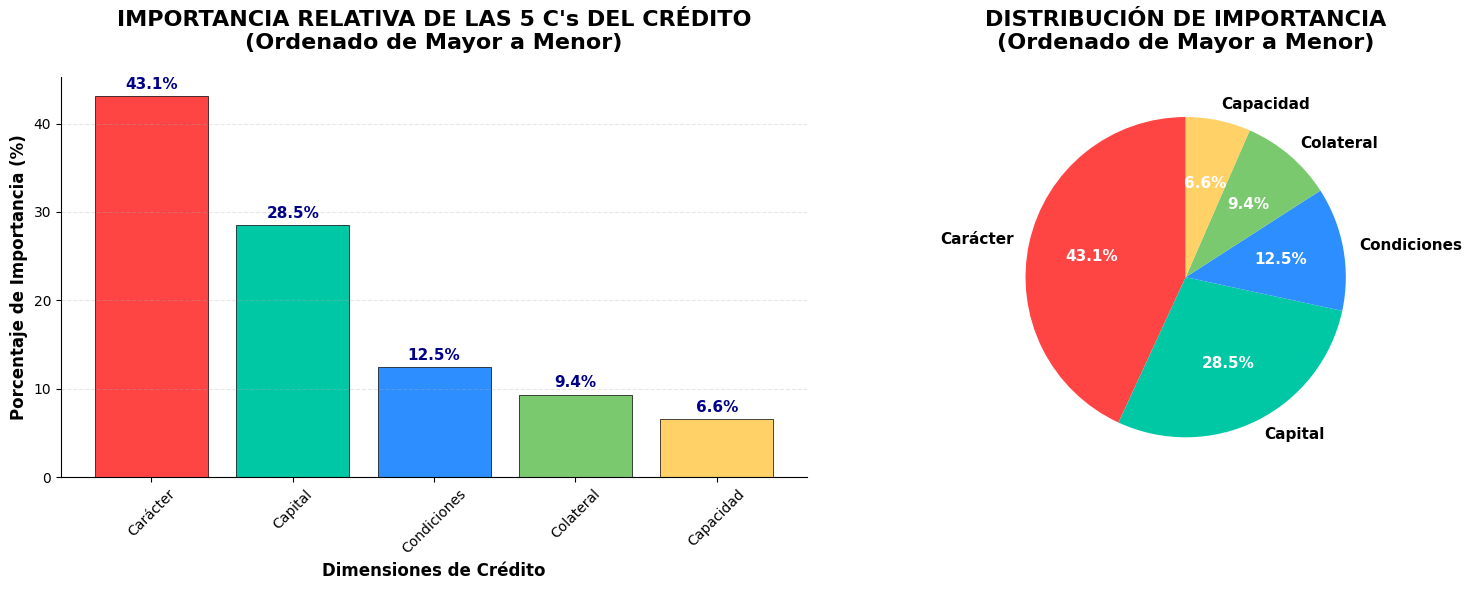

🔍 PESOS CALCULADOS (Ordenados de Mayor a Menor):
 1. Carácter     ████████              43.11%
 2. Capital      █████                 28.52%
 3. Condiciones  ██                    12.47%
 4. Colateral    █                      9.35%
 5. Capacidad    █                      6.55%
📊 TOTAL: 100.00%

💡 ANÁLISIS:
   • Dimensión más importante: Carácter (43.1%)
   • Dimensión menos importante: Capacidad (6.6%)
   • Diferencia: 36.6 puntos porcentuales
   ⚠️  Alta concentración en Carácter - considerar balancear criterios


In [5]:
def visualizar_pesos(pesos_c):
    """Visualiza la importancia de cada C ordenada de mayor a menor con más detalles"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Ordenar los pesos de mayor a menor
    pesos_ordenados = dict(sorted(pesos_c.items(), key=lambda x: x[1], reverse=True))
    categorias = list(pesos_ordenados.keys())
    valores = list(pesos_ordenados.values())
    
    # Colores degradados (más intenso para mayor importancia)
    colores = ['#FF4444', '#00C8A4', '#2D8EFF', '#7BC96F', '#FFD166']
    
    # Gráfico de barras
    barras = ax1.bar(categorias, valores, color=colores, edgecolor='black', linewidth=0.5)
    ax1.set_title('IMPORTANCIA RELATIVA DE LAS 5 C\'s DEL CRÉDITO\n(Ordenado de Mayor a Menor)', 
                 fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Porcentaje de Importancia (%)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Dimensiones de Crédito', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Añadir valores en las barras
    for barra, valor in zip(barras, valores):
        altura = barra.get_height()
        ax1.text(barra.get_x() + barra.get_width()/2., altura + 0.5,
                f'{valor:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=11, color='darkblue')
    
    # Mejorar aspecto del gráfico
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Gráfico de pie
    wedges, texts, autotexts = ax2.pie(valores, labels=categorias, autopct='%1.1f%%', 
                                      startangle=90, colors=colores, 
                                      textprops={'fontsize': 11, 'fontweight': 'bold'})
    
    # Mejorar etiquetas del pie
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax2.set_title('DISTRIBUCIÓN DE IMPORTANCIA\n(Ordenado de Mayor a Menor)', 
                 fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir resultados ordenados con formato mejorado
    print("🔍 PESOS CALCULADOS (Ordenados de Mayor a Menor):")
    print("="*50)
    total = sum(valores)
    
    for i, (c, peso) in enumerate(pesos_ordenados.items(), 1):
        proporcion = peso / total * 100
        barra = "█" * int(peso / 5)  # Cada █ representa 5%
        print(f"{i:2d}. {c:12} {barra:20} {peso:6.2f}%")
    
    print("="*50)
    print(f"📊 TOTAL: {total:.2f}%")
    
    # Análisis adicional
    mayor = categorias[0]
    menor = categorias[-1]
    diferencia = valores[0] - valores[-1]
    
    print(f"\n💡 ANÁLISIS:")
    print(f"   • Dimensión más importante: {mayor} ({valores[0]:.1f}%)")
    print(f"   • Dimensión menos importante: {menor} ({valores[-1]:.1f}%)")
    print(f"   • Diferencia: {diferencia:.1f} puntos porcentuales")
    
    if diferencia > 30:
        print(f"   ⚠️  Alta concentración en {mayor} - considerar balancear criterios")
    elif diferencia < 10:
        print(f"   ✅ Buen balance entre dimensiones")

visualizar_pesos(pesos_c)

## 4. Análisis de Valores Óptimos por Variable

In [6]:
def analizar_valores_optimos_robusto(df, variable_objetivo='target', min_casos=5):
    """
    Versión más robusta que maneja diferentes tipos de variables
    """
    resultados = {}
    
    for columna in df.select_dtypes(include=[np.number]).columns:
        if columna == variable_objetivo:
            continue
            
        print(f"\n🔍 Analizando: {columna}")
        
        # Filtrar valores nulos
        datos_validos = df[[columna, variable_objetivo]].dropna()
        if len(datos_validos) < min_casos:
            print(f"   ⚠️  Muy pocos datos válidos ({len(datos_validos)}), saltando...")
            continue
            
        valores_unicos = datos_validos[columna].nunique()
        print(f"   Valores únicos: {valores_unicos}")
        
        if valores_unicos <= 3:
            # Análisis por categorías (variables binarias o con pocos valores)
            analisis_categorico(datos_validos, columna, variable_objetivo, resultados)
            
        elif valores_unicos <= 10:
            # Análisis por deciles para variables con más valores
            analisis_deciles(datos_validos, columna, variable_objetivo, resultados, n_groups=min(5, valores_unicos))
            
        else:
            # Análisis por quintiles para variables continuas
            analisis_quintiles(datos_validos, columna, variable_objetivo, resultados)
    
    return resultados

def analisis_categorico(datos, columna, variable_objetivo, resultados):
    """Análisis para variables categóricas/booleanas"""
    metricas = datos.groupby(columna).agg({
        variable_objetivo: ['mean', 'count', 'std']
    }).round(4)
    
    # Encontrar categoría con menor incumplimiento
    if len(metricas) > 0:
        mejor_categoria = metricas[(variable_objetivo, 'mean')].idxmin()
        mejor_metricas = metricas.loc[mejor_categoria]
        
        resultados[columna] = {
            'valor_optimo': mejor_categoria,
            'tasa_incumplimiento': mejor_metricas[(variable_objetivo, 'mean')],
            'cantidad_casos': mejor_metricas[(variable_objetivo, 'count')],
            'desviacion_std': mejor_metricas[(variable_objetivo, 'std')],
            'tipo_analisis': 'categorico',
            'todas_categorias': metricas[(variable_objetivo, 'mean')].to_dict()
        }
        print(f"   ✅ Análisis categórico completado")

def analisis_deciles(datos, columna, variable_objetivo, resultados, n_groups=5):
    """Análisis para variables con pocos valores únicos"""
    try:
        # Crear grupos basados en valores únicos
        datos_temp = datos.copy()
        datos_temp['grupo'] = pd.cut(datos_temp[columna], bins=n_groups, labels=False)
        
        metricas = datos_temp.groupby('grupo').agg({
            variable_objetivo: ['mean', 'count'],
            columna: ['min', 'max']
        }).round(4)
        
        if len(metricas) > 0:
            mejor_grupo = metricas[(variable_objetivo, 'mean')].idxmin()
            mejor_rango = metricas.loc[mejor_grupo]
            
            resultados[columna] = {
                'min': mejor_rango[(columna, 'min')],
                'max': mejor_rango[(columna, 'max')],
                'tasa_incumplimiento': mejor_rango[(variable_objetivo, 'mean')],
                'cantidad_casos': mejor_rango[(variable_objetivo, 'count')],
                'grupo': mejor_grupo + 1,
                'tipo_analisis': f'deciles_{n_groups}'
            }
            print(f"   ✅ Análisis por {n_groups} grupos completado")
            
    except Exception as e:
        print(f"   ❌ Error en análisis deciles: {e}")

def analisis_quintiles(datos, columna, variable_objetivo, resultados):
    """Análisis para variables continuas con quintiles"""
    try:
        datos_temp = datos.copy()
        datos_temp['quintil'] = pd.qcut(
            datos_temp[columna], 
            q=5, 
            labels=False, 
            duplicates='drop'
        )
        
        metricas = datos_temp.groupby('quintil').agg({
            variable_objetivo: ['mean', 'count'],
            columna: ['min', 'max', 'mean']
        }).round(4)
        
        if len(metricas) > 0:
            mejor_quintil = metricas[(variable_objetivo, 'mean')].idxmin()
            mejor_rango = metricas.loc[mejor_quintil]
            
            resultados[columna] = {
                'min': mejor_rango[(columna, 'min')],
                'max': mejor_rango[(columna, 'max')],
                'mean': mejor_rango[(columna, 'mean')],
                'tasa_incumplimiento': mejor_rango[(variable_objetivo, 'mean')],
                'cantidad_casos': mejor_rango[(variable_objetivo, 'count')],
                'quintil': mejor_quintil + 1,
                'tipo_analisis': 'quintiles'
            }
            print(f"   ✅ Análisis por quintiles completado")
            
    except Exception as e:
        print(f"   ❌ Error en análisis quintiles: {e}")

# Usar la versión robusta
print("=== ANÁLISIS ROBUSTO DE VALORES ÓPTIMOS ===")
valores_optimos = analizar_valores_optimos_robusto(df)

=== ANÁLISIS ROBUSTO DE VALORES ÓPTIMOS ===

🔍 Analizando: monto
   Valores únicos: 508
   ✅ Análisis por quintiles completado

🔍 Analizando: tasaordinaria
   Valores únicos: 30
   ✅ Análisis por quintiles completado

🔍 Analizando: tasamoratoria
   Valores únicos: 30
   ✅ Análisis por quintiles completado

🔍 Analizando: frecuenciacapint
   Valores únicos: 2
   ✅ Análisis categórico completado

🔍 Analizando: montogarantialiq
   Valores únicos: 88
   ✅ Análisis por quintiles completado

🔍 Analizando: montogarantiapre
   Valores únicos: 45
   ✅ Análisis por quintiles completado

🔍 Analizando: montogarantiahipo
   Valores únicos: 1
   ✅ Análisis categórico completado

🔍 Analizando: codigo_postal
   Valores únicos: 69
   ✅ Análisis por quintiles completado

🔍 Analizando: cod_actividad
   Valores únicos: 205
   ✅ Análisis por quintiles completado

🔍 Analizando: ingresos_ordinarios
   Valores únicos: 615
   ✅ Análisis por quintiles completado

🔍 Analizando: num_dependientes
   Valores únicos:

In [7]:
valores_optimos

{'monto': {'min': np.float64(1374.0),
  'max': np.float64(15000.0),
  'mean': np.float64(10433.236),
  'tasa_incumplimiento': np.float64(0.0199),
  'cantidad_casos': np.float64(3169.0),
  'quintil': np.int64(1),
  'tipo_analisis': 'quintiles'},
 'tasaordinaria': {'min': np.float64(12.0),
  'max': np.float64(30.0),
  'mean': np.float64(28.4031),
  'tasa_incumplimiento': np.float64(0.0331),
  'cantidad_casos': np.float64(7019.0),
  'quintil': np.int64(1),
  'tipo_analisis': 'quintiles'},
 'tasamoratoria': {'min': np.float64(5.02),
  'max': np.float64(58.8),
  'mean': np.float64(51.6614),
  'tasa_incumplimiento': np.float64(0.0259),
  'cantidad_casos': np.float64(2939.0),
  'quintil': np.int64(1),
  'tipo_analisis': 'quintiles'},
 'frecuenciacapint': {'valor_optimo': np.int64(15),
  'tasa_incumplimiento': np.float64(0.0),
  'cantidad_casos': np.float64(1.0),
  'desviacion_std': np.float64(nan),
  'tipo_analisis': 'categorico',
  'todas_categorias': {15: 0.0, 30: 0.0475}},
 'montogarantial

## 5. Sistema de Scoring Automatizado

In [8]:
def crear_sistema_scoring(pesos_c, variables_por_c, valores_optimos):
    """
    Crea un sistema de scoring basado en los pesos calculados
    """
    def calcular_score_cliente(datos_cliente, df_referencia):
        """
        Calcula score para un nuevo cliente
        datos_cliente: dict con los datos del cliente
        df_referencia: dataframe histórico para normalización
        """
        score_total = 0
        scores_detalle = {}
        
        for c, peso_total in pesos_c.items():
            variables_c = variables_por_c[c]
            score_c = 0
            variables_encontradas = 0
            
            for var in variables_c:
                if var in datos_cliente and var in df_referencia.columns:
                    # Normalizar valor respecto al histórico
                    valor_cliente = datos_cliente[var]
                    valor_min = df_referencia[var].min()
                    valor_max = df_referencia[var].max()
                    
                    # Puntuar basado en proximidad al valor óptimo
                    if var in valores_optimos:
                        optimo_medio = (valores_optimos[var]['min'] + valores_optimos[var]['max']) / 2
                        distancia = abs(valor_cliente - optimo_medio) / (valor_max - valor_min)
                        puntuacion = max(0, 1 - distancia)
                    else:
                        # Para variables donde más alto es mejor
                        puntuacion = (valor_cliente - valor_min) / (valor_max - valor_min)
                    
                    score_c += puntuacion
                    variables_encontradas += 1
            
            if variables_encontradas > 0:
                score_c = (score_c / variables_encontradas) * (peso_total / 100)
                score_total += score_c
                scores_detalle[c] = score_c
        
        return min(1000, score_total * 1000), scores_detalle
    
    return calcular_score_cliente

# Ejemplo de uso
sistema_scoring = crear_sistema_scoring(pesos_c, variables_por_c, valores_optimos)

# Probar con un cliente nuevo
cliente_ejemplo = {
    'puntaje_credito': 720,
    'antiguedad_credito': 4,
    'ingreso_mensual': 4500,
    'dti': 0.30,
    'ahorros': 18000,
    'valor_garantia': 28000,
    'ltv': 0.72,
    'estabilidad_empleo': 3
}

score, detalle = sistema_scoring(cliente_ejemplo, df)
print(f"\nSCORE DEL CLIENTE: {score:.0f}/1000")
print("Desglose por C:")
for c, puntaje in detalle.items():
    print(f"  {c}: {puntaje:.2f}")


SCORE DEL CLIENTE: 0/1000
Desglose por C:


## 6. Recomendaciones Estratégicas

In [9]:
def generar_recomendaciones_minima(pesos_c, valores_optimos, df):
    """
    Versión mínima y segura
    """
    print("\n" + "="*50)
    print("RECOMENDACIONES ESTRATÉGICAS")
    print("="*50)
    
    # 1. Enfoque principal
    if pesos_c:
        c_principal = max(pesos_c.items(), key=lambda x: x[1])
        print(f"\n1. ENFOQUE PRINCIPAL: '{c_principal[0]}'")
        print(f"   Peso: {c_principal[1]:.1f}%")
    
    # 2. Recomendaciones por C
    print(f"\n2. RECOMENDACIONES POR DIMENSIÓN:")
    for c, peso in sorted(pesos_c.items(), key=lambda x: x[1], reverse=True):
        print(f"\n   {c} ({peso:.1f}%):")
        
        if c == 'Character':
            print("   • Verificación robusta de historial crediticio")
        elif c == 'Capacity': 
            print("   • Enfoque en DTI < 35%")
        elif c == 'Capital':
            print("   • Ahorros de 3-6 meses de pagos")
        elif c == 'Collateral':
            print("   • LTV máximo 80%")
        elif c == 'Conditions':
            print("   • Antigüedad laboral > 2 años")
    
    # 3. Variables óptimas (formato seguro)
    print(f"\n3. VARIABLES ÓPTIMAS:")
    for i, (var, optimo) in enumerate(list(valores_optimos.items())[:5]):
        tasa = optimo.get('tasa_incumplimiento', 0)
        
        if 'valor_optimo' in optimo:
            valor = optimo['valor_optimo']
            print(f"   {i+1}. {var}: {valor} (Riesgo: {tasa:.1%})")
        else:
            min_val = optimo.get('min', '?')
            max_val = optimo.get('max', '?')
            print(f"   {i+1}. {var}: {min_val} a {max_val} (Riesgo: {tasa:.1%})")

# Ejecutar la versión mínima
generar_recomendaciones_minima(pesos_c, valores_optimos, df)


RECOMENDACIONES ESTRATÉGICAS

1. ENFOQUE PRINCIPAL: 'Carácter'
   Peso: 43.1%

2. RECOMENDACIONES POR DIMENSIÓN:

   Carácter (43.1%):

   Capital (28.5%):
   • Ahorros de 3-6 meses de pagos

   Condiciones (12.5%):

   Colateral (9.4%):

   Capacidad (6.6%):

3. VARIABLES ÓPTIMAS:
   1. monto: 1374.0 a 15000.0 (Riesgo: 2.0%)
   2. tasaordinaria: 12.0 a 30.0 (Riesgo: 3.3%)
   3. tasamoratoria: 5.02 a 58.8 (Riesgo: 2.6%)
   4. frecuenciacapint: 15 (Riesgo: 0.0%)
   5. montogarantialiq: 0.0 a 1000.0 (Riesgo: 2.0%)


## CreditScoring

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# 1. FEATURE ENGINEERING ESPECÍFICO PARA RIESGO CREDITICIO
# =============================================================================

def feature_engineering_credito(df):
    """
    Feature engineering específico para riesgo crediticio
    """
    print("🔧 Aplicando Feature Engineering para riesgo crediticio...")
    df_eng = df.copy()
    
    # 1. RATIOS FINANCIEROS Y DE CAPACIDAD DE PAGO
    print("   - Creando ratios financieros...")
    
    # Ratio deuda/ingresos (simulado)
    if 'ingresos_ordinarios' in df.columns:
        # Convertir deudas a numérico si es categórico
        if 'deudas' in df.columns and df['deudas'].dtype == 'object':
            deudas_map = {
                'SIN DEUDAS': 0,
                'DEUDAS DEL 1% AL 20% DEL PATRIMONIO': 0.1,
                'DEUDAS DEL 21% AL 40% DEL PATRIMONIO': 0.3,
                'DEUDAS DEL 41% AL 60% DEL PATRIMONIO': 0.5,
                'DEUDAS MAYORES AL 60% DEL PATRIMONIO': 0.8
            }
            df_eng['deudas_numeric'] = df['deudas'].map(deudas_map).fillna(0)
            df_eng['deuda_ingreso_ratio'] = df_eng['deudas_numeric'] / (df['ingresos_ordinarios'] + 1e-6)
        elif 'deudas' in df.columns:
            df_eng['deuda_ingreso_ratio'] = df['deudas'] / (df['ingresos_ordinarios'] + 1e-6)
    
    # 2. INTERACCIONES ENTRE VARIABLES CLAVE
    if 'monto' in df.columns and 'ingresos_ordinarios' in df.columns:
        df_eng['monto_ingreso_ratio'] = df['monto'] / (df['ingresos_ordinarios'] + 1e-6)
    
    if 'montogarantialiq' in df.columns and 'monto' in df.columns:
        df_eng['cobertura_garantia'] = df['montogarantialiq'] / (df['monto'] + 1e-6)
    
    # 3. VARIABLES TEMPORALES Y COMPORTAMIENTO
    if 'plazocredito' in df.columns:
        # Convertir plazocredito a numérico
        if df['plazocredito'].dtype == 'object':
            plazo_extract = df['plazocredito'].str.extract('(\d+)')
            if not plazo_extract.empty:
                df_eng['plazo_meses'] = plazo_extract[0].astype(float)
            else:
                df_eng['plazo_meses'] = 12  # Valor por defecto
        else:
            df_eng['plazo_meses'] = df['plazocredito']
    
    # 4. SCORING COMPUESTO DE HISTORIAL CREDITICIO
    print("   - Creando scores de historial crediticio...")
    historial_map = {
        'PAGO PUNTUAL(CALIF. A)': 1.0,
        'HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B)': 0.6,
        'MAS DE 5 ATRASOS MENORES DE 7 DIAS(CALIF. C)': 0.3,
        'ATRASOS MAYORES A 7 DIAS(CALIF. D)': 0.1,
        'SIN HISTORIAL': 0.5
    }
    
    if 'exp_cred_interna' in df.columns:
        df_eng['score_historial_interno'] = df['exp_cred_interna'].map(
            lambda x: historial_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # Mapeo similar para experiencia crediticia externa
    if 'exp_cred_externa' in df.columns:
        df_eng['score_historial_externo'] = df['exp_cred_externa'].map(
            lambda x: historial_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # 5. VARIABLES DE ESTABILIDAD LABORAL
    print("   - Creando variables de estabilidad...")
    if 'empleo' in df.columns:
        estabilidad_map = {
            'EMPLEO PERMANENTE': 1.0,
            'EMPLEO TEMPORAL': 0.6,
            'INDEPENDIENTE': 0.7,
            'DESEMPLEADO': 0.2,
            'AUTÓNOMO': 0.7
        }
        df_eng['estabilidad_empleo_score'] = df['empleo'].map(
            lambda x: estabilidad_map.get(x, 0.5) if pd.notna(x) else 0.5
        )
    
    # 6. VARIABLES DE DIVERSIFICACIÓN GEOGRÁFICA/COMERCIAL
    if 'comercio_en_region' in df.columns:
        df_eng['presencia_regional'] = df['comercio_en_region'].map({'SI': 1, 'NO': 0, 'Sí': 1, 'No': 0}).fillna(0)
    
    if 'permiso_para_funcionar' in df.columns:
        df_eng['permiso_funcionamiento'] = df['permiso_para_funcionar'].map({'SI': 1, 'NO': 0, 'Sí': 1, 'No': 0}).fillna(0)
    
    # 7. SCORING COMPUESTO DE LAS 5Cs
    print("   - Calculando scores compuestos...")
    
    # Carácter (Historial crediticio + Estabilidad)
    caracter_vars = [v for v in ['score_historial_interno', 'score_historial_externo', 'estabilidad_empleo_score'] 
                    if v in df_eng.columns]
    if caracter_vars:
        df_eng['score_caracter'] = df_eng[caracter_vars].mean(axis=1)
    
    # Capacidad (Ratios financieros)
    capacidad_vars = [v for v in ['deuda_ingreso_ratio', 'monto_ingreso_ratio'] if v in df_eng.columns]
    if capacidad_vars:
        # Invertir ratios (menor ratio = mejor capacidad)
        for var in capacidad_vars:
            df_eng[f'score_{var}'] = 1 / (df_eng[var] + 0.01)
        
        score_vars = [f'score_{v}' for v in capacidad_vars if f'score_{v}' in df_eng.columns]
        if score_vars:
            df_eng['score_capacidad'] = df_eng[score_vars].mean(axis=1)
    
    # Colateral (Cobertura de garantías)
    colateral_vars = [v for v in ['cobertura_garantia'] if v in df_eng.columns]
    if colateral_vars:
        df_eng['score_colateral'] = df_eng[colateral_vars].mean(axis=1)
    
    # 8. VARIABLES BINARIAS DE RIESGO
    # Indicador de alto riesgo basado en múltiples factores
    condiciones_riesgo = []
    if 'deuda_ingreso_ratio' in df_eng.columns:
        condiciones_riesgo.append(df_eng['deuda_ingreso_ratio'] > 0.5)
    if 'score_historial_interno' in df_eng.columns:
        condiciones_riesgo.append(df_eng['score_historial_interno'] < 0.3)
    
    if condiciones_riesgo:
        df_eng['alto_riesgo'] = np.any(condiciones_riesgo, axis=0).astype(int)
    
    print("✅ Feature engineering completado")
    print(f"   Nuevas variables creadas: {len(df_eng.columns) - len(df.columns)}")
    
    return df_eng

# =============================================================================
# 2. CÁLCULO DETALLADO DEL VALOR DE CADA CARACTERÍSTICA PARA CADA C
# =============================================================================

def calcular_valor_detallado_5c(df, variable_objetivo='target'):
    """
    Calcula el valor detallado de cada característica para cada una de las 5 Cs
    """
    print("\n📊 Calculando importancia detallada por característica...")
    
    # Mapeo de variables a cada C (expandido)
    variables_por_c = {
        "Carácter": ["reputaciÓn_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        #"Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        #"Colateral": ["solidario", "pro_comunal", "pro_privada","lÍquida"]
    }
    
    # Filtrar variables que existen en el dataframe
    variables_por_c = {c: [v for v in vars_list if v in df.columns] 
                      for c, vars_list in variables_por_c.items()}
    
    # Preparar datos
    X = df.drop(columns=[variable_objetivo] if variable_objetivo in df.columns else [])
    y = df[variable_objetivo] if variable_objetivo in df.columns else None
    
    if y is None:
        print("❌ Variable objetivo no encontrada")
        return None, None, None
    
    # Codificar variables categóricas
    print("   - Codificando variables categóricas...")
    X_encoded = pd.get_dummies(X, drop_first=True)
    
    # Entrenar modelo con validación
    print("   - Entrenando modelo Random Forest...")
    model = RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        max_depth=10,
        min_samples_split=5
    )
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_encoded, y, cv=10, scoring='roc_auc')
    print(f"   - AUC Promedio (CV): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    model.fit(X_encoded, y)
    
    # Obtener importancia de características
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calcular importancia detallada por C y por variable
    print("   - Calculando importancia por categoría...")
    resultados_detallados = {}
    
    for c, variables in variables_por_c.items():
        print(f"     Procesando {c}...")
        c_results = {}
        total_c_importance = 0
        
        for variable in variables:
            # Buscar todas las características relacionadas con esta variable
            relevant_features = []
            
            # Para variables originales
            if variable in X.columns:
                if X[variable].dtype == 'object':
                    # Variables categóricas (dummies)
                    relevant_features = [f for f in feature_importance['feature'] 
                                       if f.startswith(f"{variable}_")]
                else:
                    # Variables numéricas
                    relevant_features = [variable] if variable in feature_importance['feature'].values else []
            
            # Para variables de feature engineering (ya deberían estar en X_encoded)
            elif variable in X_encoded.columns:
                relevant_features = [variable]
            
            # Calcular importancia total de la variable
            if relevant_features:
                var_importance = feature_importance[
                    feature_importance['feature'].isin(relevant_features)
                ]['importance'].sum()
                
                total_c_importance += var_importance
                c_results[variable] = {
                    'importancia': var_importance,
                    'caracteristicas': relevant_features,
                    'importancia_promedio_por_feature': var_importance / len(relevant_features) if relevant_features else 0
                }
        
        # Calcular porcentajes dentro de la C
        for var_name, var_info in c_results.items():
            if total_c_importance > 0:
                porcentaje_dentro_c = (var_info['importancia'] / total_c_importance) * 100
            else:
                porcentaje_dentro_c = 0
            c_results[var_name]['porcentaje_dentro_c'] = porcentaje_dentro_c
        
        resultados_detallados[c] = {
            'variables': c_results,
            'importancia_total': total_c_importance,
            'numero_variables': len(c_results)
        }
    
    # Calcular importancia total y porcentajes globales
    importancia_total_global = sum([info['importancia_total'] for info in resultados_detallados.values()])
    
    for c, info in resultados_detallados.items():
        if importancia_total_global > 0:
            porcentaje_global = (info['importancia_total'] / importancia_total_global) * 100
        else:
            porcentaje_global = 0
        resultados_detallados[c]['porcentaje_global'] = porcentaje_global
    
    print("✅ Cálculo de importancia completado")
    return resultados_detallados, feature_importance, variables_por_c, cv_scores

# =============================================================================
# 3. VISUALIZACIÓN DE RESULTADOS DETALLADOS
# =============================================================================

def visualizar_resultados_detallados(resultados_detallados):
    """
    Visualiza los resultados detallados del análisis de las 5 Cs
    """
    print("\n📈 Generando visualizaciones...")
    
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Importancia global de cada C
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    categorias = list(resultados_detallados.keys())
    porcentajes = [resultados_detallados[c]['porcentaje_global'] for c in categorias]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    bars = ax1.bar(categorias, porcentajes, color=colors, alpha=0.8)
    ax1.set_title('IMPORTANCIA RELATIVA DE LAS 5 Cs\n(Porcentaje Global del Modelo)', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Porcentaje (%)', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Añadir valores en las barras
    for bar, porcentaje in zip(bars, porcentajes):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{porcentaje:.1f}%', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)
    
    # 2. Número de variables por C
    ax2 = plt.subplot2grid((3, 3), (0, 2))
    num_variables = [resultados_detallados[c]['numero_variables'] for c in categorias]
    bars = ax2.bar(categorias, num_variables, color=colors, alpha=0.8)
    ax2.set_title('NÚMERO DE VARIABLES\npor Categoría', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('Número de Variables', fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, num in zip(bars, num_variables):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{num}', ha='center', va='bottom', 
                fontweight='bold', fontsize=11)
    
    # 3. Distribución detallada por C (Top variables)
    axes_positions = [(1, 0), (1, 1), (1, 2), (2, 0), (2, 1)]
    
    for i, (categoria, info) in enumerate(resultados_detallados.items()):
        if i < len(axes_positions):
            ax = plt.subplot2grid((3, 3), axes_positions[i])
            
            variables = list(info['variables'].keys())
            importancias = [info['variables'][var]['importancia'] for var in variables]
            porcentajes = [info['variables'][var]['porcentaje_dentro_c'] for var in variables]
            
            # Tomar solo las top 5 variables por importancia
            if len(variables) > 5:
                idx_top5 = np.argsort(importancias)[-5:][::-1]
                variables = [variables[i] for i in idx_top5]
                porcentajes = [porcentajes[i] for i in idx_top5]
            
            # Acortar nombres largos para mejor visualización
            variables_short = [v[:15] + '...' if len(v) > 15 else v for v in variables]
            
            colors_pie = plt.cm.Set3(np.linspace(0, 1, len(variables)))
            wedges, texts, autotexts = ax.pie(porcentajes, labels=variables_short, 
                                            autopct='%1.1f%%', colors=colors_pie, 
                                            startangle=90, textprops={'fontsize': 9})
            
            for autotext in autotexts:
                autotext.set_color('black')
                autotext.set_fontweight('bold')
                autotext.set_fontsize(8)
            
            ax.set_title(f'{categoria}\n(Variables más importantes)', 
                        fontsize=11, fontweight='bold', pad=10)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Tabla resumen detallada
    print("\n" + "="*100)
    print("📋 RESUMEN DETALLADO POR VARIABLE")
    print("="*100)
    
    for categoria, info in resultados_detallados.items():
        print(f"\n🔍 {categoria.upper()} ({info['porcentaje_global']:.1f}% del total)")
        print("-" * 80)
        
        # Ordenar variables por importancia
        variables_ordenadas = sorted(info['variables'].items(), 
                                   key=lambda x: x[1]['importancia'], reverse=True)
        
        for var_name, var_info in variables_ordenadas:
            stars = "⭐" * min(5, max(1, int(var_info['porcentaje_dentro_c'] / 20)))
            print(f"  {stars} {var_name}:")
            print(f"     📊 Importancia: {var_info['importancia']:.6f}")
            print(f"     📈 Porcentaje dentro de {categoria}: {var_info['porcentaje_dentro_c']:.1f}%")
            print(f"     🔢 Características: {len(var_info['caracteristicas'])}")
            
            # Mostrar top features si son relevantes
            if var_info['caracteristicas']:
                top_features = var_info['caracteristicas'][:3]
                if len(var_info['caracteristicas']) > 3:
                    top_features.append(f"... (+{len(var_info['caracteristicas']) - 3} más)")
                print(f"     🎯 Features principales: {', '.join(top_features)}")
            
            print()

# =============================================================================
# 4. FUNCIÓN PARA EXPORTAR RESULTADOS
# =============================================================================

def exportar_resultados_completos(resultados_detallados, filename="analisis_5cs_completo.xlsx"):
    """
    Exporta a un archivo Excel:
      - Resumen por categoría (5 Cs)
      - Detalle por variable dentro de cada C
      - Lista de features relacionadas por variable
    """
    print(f"\n💾 Exportando resultados a {filename}...")

    try:
        with pd.ExcelWriter(filename, engine="openpyxl") as writer:

            # ---------------------------------------------------------------------
            # 1. RESUMEN POR CATEGORÍA
            # ---------------------------------------------------------------------
            resumen_data = []
            for categoria, info in resultados_detallados.items():
                resumen_data.append({
                    "Categoría": categoria,
                    "Importancia Total": info["importancia_total"],
                    "Porcentaje Global (%)": info["porcentaje_global"],
                    "Número de Variables": info["numero_variables"]
                })

            df_resumen = pd.DataFrame(resumen_data)
            df_resumen.to_excel(writer, sheet_name="Resumen por Categoría", index=False)

            # ---------------------------------------------------------------------
            # 2. DETALLE POR VARIABLE
            # ---------------------------------------------------------------------
            detalle_data = []
            for categoria, info in resultados_detallados.items():
                for var_name, var_info in info["variables"].items():
                    detalle_data.append({
                        "Categoría": categoria,
                        "Variable": var_name,
                        "Importancia": var_info["importancia"],
                        "Porcentaje Dentro C (%)": var_info["porcentaje_dentro_c"],
                        "Número de Features Asociadas": len(var_info["caracteristicas"])
                    })

            df_detalle = pd.DataFrame(detalle_data)
            df_detalle.to_excel(writer, sheet_name="Detalle por Variable", index=False)

            # ---------------------------------------------------------------------
            # 3. FEATURES ASOCIADAS POR VARIABLE
            # ---------------------------------------------------------------------
            features_data = []
            for categoria, info in resultados_detallados.items():
                for var_name, var_info in info["variables"].items():
                    for feat in var_info["caracteristicas"]:
                        features_data.append({
                            "Categoría": categoria,
                            "Variable": var_name,
                            "Feature Asociada": feat,
                            "Importancia Feature": None  # Opcional: puedes agregar aquí si guardas importancia por feature
                        })

            df_features = pd.DataFrame(features_data)
            df_features.to_excel(writer, sheet_name="Features por Variable", index=False)

    except Exception as e:
        print(f"❌ Error al exportar resultados: {e}")
        return

    print("✅ Exportación completada con éxito.")
# =============================================================================
# 5. EJECUCIÓN PRINCIPAL
# =============================================================================

def analisis_completo_5cs(df):
    """
    Función principal que ejecuta todo el análisis
    """
    print("🚀 INICIANDO ANÁLISIS COMPLETO DE LAS 5 Cs")
    print("=" * 60)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # Mostrar nuevas variables creadas
    nuevas_variables = set(df_enhanced.columns) - set(df.columns)
    print(f"\n📋 Variables creadas en el feature engineering ({len(nuevas_variables)}):")
    for i, var in enumerate(sorted(nuevas_variables), 1):
        print(f"   {i:2d}. {var}")
    
    # 2. Cálculo detallado de importancia
    resultados_detallados, feature_importance, variables_por_c, cv_scores = calcular_valor_detallado_5c(df_enhanced)
    
    if resultados_detallados is None:
        print("❌ No se pudo completar el análisis")
        return
    
    # 3. Visualización
    visualizar_resultados_detallados(resultados_detallados)
    
    # 4. Exportación
    exportar_resultados_completos(resultados_detallados)
    
    # 5. Resumen ejecutivo
    print("\n🎯 RESUMEN EJECUTIVO")
    print("=" * 50)
    
    # Categoría más importante
    cat_importante = max(resultados_detallados.items(), key=lambda x: x[1]['porcentaje_global'])
    print(f"📊 Categoría más importante: {cat_importante[0]} ({cat_importante[1]['porcentaje_global']:.1f}%)")
    
    # Variable más importante globalmente
    todas_variables = []
    for categoria, info in resultados_detallados.items():
        for var_name, var_info in info['variables'].items():
            todas_variables.append((var_name, categoria, var_info['importancia']))
    
    if todas_variables:
        var_importante = max(todas_variables, key=lambda x: x[2])
        print(f"⭐ Variable más importante: {var_importante[0]} ({var_importante[1]})")
    
    print(f"🔢 Total de variables analizadas: {sum([info['numero_variables'] for info in resultados_detallados.values()])}")
    print(f"📈 Performance del modelo (AUC): {cv_scores.mean():.3f}")
    
    return df_enhanced, resultados_detallados, feature_importance
def analizar_pesos_valores_categoricos(df, variable_objetivo='target'):
    """
    Analiza el peso de cada valor categórico dentro de las variables de las 5 Cs
    """
    print("\n🔍 ANALIZANDO PESOS DE VALORES CATEGÓRICOS")
    print("=" * 60)
    
    # Mapeo de variables categóricas por cada C
    variables_categoricas_por_c = {
        "Carácter": ["reputaciÓn_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        #"Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        #"Colateral": ["solidario", "pro_comunal", "pro_privada","lÍquida"]
    }
    
    # Filtrar variables que existen y son categóricas
    variables_analizar = {}
    for c, vars_list in variables_categoricas_por_c.items():
        vars_existentes = []
        for var in vars_list:
            if var in df.columns and df[var].dtype == 'object':
                vars_existentes.append(var)
        if vars_existentes:
            variables_analizar[c] = vars_existentes
    
    resultados_pesos = {}
    
    for categoria, variables in variables_analizar.items():
        print(f"\n📊 {categoria}:")
        print("-" * 40)
        resultados_pesos[categoria] = {}
        
        for variable in variables:
            print(f"  🔸 {variable}:")
            
            # Calcular tasa de mora por categoría
            conteo_por_valor = df.groupby(variable)[variable_objetivo].agg([
                'count', 
                'mean',  # Tasa de mora
                'sum'    # Número de morosos
            ]).round(4)
            
            # Ordenar por tasa de mora (de mayor a menor riesgo)
            conteo_por_valor = conteo_por_valor.sort_values('mean', ascending=False)
            
            # Calcular peso relativo (normalizado)
            if len(conteo_por_valor) > 1:
                tasa_min = conteo_por_valor['mean'].min()
                tasa_max = conteo_por_valor['mean'].max()
                if tasa_max > tasa_min:
                    conteo_por_valor['peso_riesgo'] = (
                        (conteo_por_valor['mean'] - tasa_min) / (tasa_max - tasa_min)
                    ).round(4)
                else:
                    conteo_por_valor['peso_riesgo'] = 0.5
            else:
                conteo_por_valor['peso_riesgo'] = 0.5
            
            # Calponderación por frecuencia
            total_casos = conteo_por_valor['count'].sum()
            conteo_por_valor['ponderacion'] = (conteo_por_valor['count'] / total_casos).round(4)
            
            resultados_pesos[categoria][variable] = conteo_por_valor
            
            # Mostrar resultados
            for valor, fila in conteo_por_valor.iterrows():
                stars = "⚠️" * min(5, max(1, int(fila['peso_riesgo'] * 5)))
                print(f"     {stars} {valor}:")
                print(f"        📈 Tasa mora: {fila['mean']:.1%}")
                print(f"        🎯 Peso riesgo: {fila['peso_riesgo']:.3f}")
                print(f"        📊 Casos: {fila['count']} ({fila['ponderacion']:.1%})")
                print(f"        🔢 Morosos: {int(fila['sum'])}")
            
            print()
    
    return resultados_pesos

def exportar_pesos_detallados(resultados_pesos, resultados_detallados, filename="pesos_detallados_5cs.xlsx"):
    """
    Exporta los pesos detallados de cada valor categórico a Excel
    """
    print(f"\n💾 Exportando pesos detallados a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # 1. Resumen por categoría y variable
            resumen_data = []
            for categoria, variables in resultados_pesos.items():
                for variable, datos in variables.items():
                    for valor, fila in datos.iterrows():
                        resumen_data.append({
                            'Categoría': categoria,
                            'Variable': variable,
                            'Valor': valor,
                            'Tasa_Mora': fila['mean'],
                            'Peso_Riesgo': fila['peso_riesgo'],
                            'Número_Casos': fila['count'],
                            'Porcentaje_Casos': fila['ponderacion'],
                            'Número_Morosos': fila['sum'],
                            'Riesgo_Cualitativo': 'ALTO' if fila['peso_riesgo'] > 0.7 else 
                                                'MEDIO' if fila['peso_riesgo'] > 0.3 else 'BAJO'
                        })
            
            df_resumen = pd.DataFrame(resumen_data)
            df_resumen.to_excel(writer, sheet_name='Pesos por Valor', index=False)
            
            # 2. Top valores de riesgo por categoría
            top_riesgo_data = []
            for categoria, variables in resultados_pesos.items():
                for variable, datos in variables.items():
                    top_valor = datos.loc[datos['peso_riesgo'].idxmax()]
                    top_riesgo_data.append({
                        'Categoría': categoria,
                        'Variable': variable,
                        'Valor_Más_Riesgoso': datos['peso_riesgo'].idxmax(),
                        'Peso_Riesgo_Máximo': top_valor['peso_riesgo'],
                        'Tasa_Mora_Máxima': top_valor['mean'],
                        'Número_Casos_Riesgo': top_valor['count']
                    })
            
            df_top_riesgo = pd.DataFrame(top_riesgo_data)
            df_top_riesgo.to_excel(writer, sheet_name='Top Valores Riesgo', index=False)
            
            # 3. Matriz de riesgo por categoría
            matriz_data = []
            for categoria, info in resultados_detallados.items():
                if categoria in resultados_pesos:
                    num_variables_analizadas = len(resultados_pesos[categoria])
                    peso_promedio = np.mean([
                        datos['peso_riesgo'].mean() 
                        for datos in resultados_pesos[categoria].values()
                    ]) if num_variables_analizadas > 0 else 0
                    
                    matriz_data.append({
                        'Categoría': categoria,
                        'Variables_Analizadas': num_variables_analizadas,
                        'Peso_Riesgo_Promedio': round(peso_promedio, 4),
                        'Nivel_Riesgo': 'ALTO' if peso_promedio > 0.6 else 
                                      'MEDIO-ALTO' if peso_promedio > 0.4 else
                                      'MEDIO' if peso_promedio > 0.2 else 'BAJO'
                    })
            
            df_matriz = pd.DataFrame(matriz_data)
            df_matriz.to_excel(writer, sheet_name='Matriz Riesgo por C', index=False)
            
        print(f"✅ Pesos detallados exportados exitosamente a: {filename}")
        
    except Exception as e:
        print(f"❌ Error al exportar pesos: {e}")

def visualizar_pesos_valores(resultados_pesos):
    """
    Visualiza los pesos de los valores categóricos
    """
    print("\n📊 GENERANDO VISUALIZACIONES DE PESOS...")
    
    # Crear figura con subplots
    n_categorias = len(resultados_pesos)
    fig, axes = plt.subplots(n_categorias, 1, figsize=(14, 5 * n_categorias))
    
    if n_categorias == 1:
        axes = [axes]
    
    for idx, (categoria, variables) in enumerate(resultados_pesos.items()):
        ax = axes[idx]
        
        # Preparar datos para el gráfico
        datos_grafico = []
        etiquetas = []
        colores = []
        
        for variable, datos in variables.items():
            for valor, fila in datos.iterrows():
                datos_grafico.append(fila['peso_riesgo'])
                etiquetas.append(f"{variable}\n{valor}")
                
                # Color basado en el nivel de riesgo
                if fila['peso_riesgo'] > 0.7:
                    colores.append('#ff6b6b')  # Rojo - alto riesgo
                elif fila['peso_riesgo'] > 0.4:
                    colores.append('#ffd166')  # Amarillo - medio riesgo
                else:
                    colores.append('#06d6a0')  # Verde - bajo riesgo
        
        # Crear gráfico de barras
        bars = ax.barh(etiquetas, datos_grafico, color=colores, alpha=0.8)
        ax.set_title(f'PESOS DE RIESGO - {categoria.upper()}', fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Peso de Riesgo (0 = Mínimo, 1 = Máximo)', fontweight='bold')
        ax.set_xlim(0, 1)
        
        # Añadir valores en las barras
        for bar, valor in zip(bars, datos_grafico):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{valor:.3f}', ha='left', va='center', fontweight='bold')
        
        # Añadir línea de referencia
        ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Límite riesgo medio')
        ax.legend()
        
        # Mejorar layout
        plt.tight_layout()
    
    plt.show()
    
    # Gráfico de calor de riesgos
    if resultados_pesos:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Preparar matriz para heatmap
        matriz_riesgo = []
        etiquetas_filas = []
        
        for categoria, variables in resultados_pesos.items():
            for variable, datos in variables.items():
                for valor, fila in datos.iterrows():
                    matriz_riesgo.append([fila['peso_riesgo'], fila['mean']])
                    etiquetas_filas.append(f"{categoria[:3]}-{variable[:10]}\n{valor[:15]}")
        
        if matriz_riesgo:
            matriz_riesgo = np.array(matriz_riesgo)
            
            # Crear heatmap
            im = ax.imshow(matriz_riesgo, cmap='RdYlGn_r', aspect='auto')
            
            # Configurar ejes
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['Peso Riesgo', 'Tasa Mora'])
            ax.set_yticks(range(len(etiquetas_filas)))
            ax.set_yticklabels(etiquetas_filas, fontsize=8)
            
            # Añadir valores en las celdas
            for i in range(len(etiquetas_filas)):
                for j in range(2):
                    text = ax.text(j, i, f'{matriz_riesgo[i, j]:.3f}',
                                 ha="center", va="center", color="black", fontweight='bold', fontsize=7)
            
            ax.set_title('MAPA DE CALOR - PESOS DE RIESGO vs TASAS DE MORA', 
                        fontsize=14, fontweight='bold', pad=20)
            plt.colorbar(im, ax=ax, label='Escala de Riesgo')
        
        plt.tight_layout()
        plt.show()

# FUNCIÓN PRINCIPAL ACTUALIZADA
def analisis_completo_5cs_con_pesos(df):
    """
    Función principal que ejecuta todo el análisis incluyendo pesos de valores
    """
    print("🚀 INICIANDO ANÁLISIS COMPLETO DE LAS 5 Cs CON PESOS DETALLADOS")
    print("=" * 70)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # Mostrar nuevas variables creadas
    nuevas_variables = set(df_enhanced.columns) - set(df.columns)
    print(f"\n📋 Variables creadas en el feature engineering ({len(nuevas_variables)}):")
    for i, var in enumerate(sorted(nuevas_variables), 1):
        print(f"   {i:2d}. {var}")
    
    # 2. Cálculo detallado de importancia
    resultados_detallados, feature_importance, variables_por_c, cv_scores = calcular_valor_detallado_5c(df_enhanced)
    
    if resultados_detallados is None:
        print("❌ No se pudo completar el análisis")
        return
    
    # 3. Análisis de pesos de valores categóricos
    resultados_pesos = analizar_pesos_valores_categoricos(df_enhanced)
    
    # 4. Visualizaciones
    visualizar_resultados_detallados(resultados_detallados)
    visualizar_pesos_valores(resultados_pesos)
    
    # 5. Exportaciones
    exportar_resultados_completos(resultados_detallados)
    exportar_pesos_detallados(resultados_pesos, resultados_detallados)
    
    # 6. Resumen ejecutivo
    print("\n🎯 RESUMEN EJECUTIVO COMPLETO")
    print("=" * 50)
    
    # Categoría más importante
    cat_importante = max(resultados_detallados.items(), key=lambda x: x[1]['porcentaje_global'])
    print(f"📊 Categoría más importante: {cat_importante[0]} ({cat_importante[1]['porcentaje_global']:.1f}%)")
    
    # Variable más importante globalmente
    todas_variables = []
    for categoria, info in resultados_detallados.items():
        for var_name, var_info in info['variables'].items():
            todas_variables.append((var_name, categoria, var_info['importancia']))
    
    if todas_variables:
        var_importante = max(todas_variables, key=lambda x: x[2])
        print(f"⭐ Variable más importante: {var_importante[0]} ({var_importante[1]})")
    
    # Valor más riesgoso
    print("\n⚠️  VALORES MÁS RIESGOSOS POR CATEGORÍA:")
    for categoria, variables in resultados_pesos.items():
        for variable, datos in variables.items():
            valor_riesgoso = datos['peso_riesgo'].idxmax()
            peso = datos.loc[valor_riesgoso, 'peso_riesgo']
            tasa = datos.loc[valor_riesgoso, 'mean']
            print(f"   🔴 {categoria} - {variable}: '{valor_riesgoso}' (Peso: {peso:.3f}, Tasa: {tasa:.1%})")
    
    print(f"\n🔢 Total de variables analizadas: {sum([info['numero_variables'] for info in resultados_detallados.values()])}")
    print(f"📈 Performance del modelo (AUC): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return df_enhanced, resultados_detallados, resultados_pesos, feature_importance, cv_scores

# EJECUCIÓN FINAL
def ejecutar_analisis_completo():
    """
    Ejecuta el análisis completo con todos los componentes
    """
    try:
        resultados = analisis_completo_5cs_con_pesos(df)
        print("\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
        return resultados
    except Exception as e:
        print(f"❌ Error en el análisis: {e}")
        print("💡 Asegúrate de que el DataFrame 'df' esté cargado correctamente")

def crear_sistema_scoring(df, variable_objetivo='target'):
    """
    Crea un sistema de scoring donde cada valor categórico tiene un puntaje numérico
    que puede sumarse para obtener un score total por socio
    """
    print("\n🎯 CREANDO SISTEMA DE SCORING NUMÉRICO")
    print("=" * 60)
    
    # Mapeo de variables categóricas para scoring
    variables_scoring = {
        "Carácter": ["reputaciÓn_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"],
        #"Condiciones": ["permiso_para_funcionar", "comercio_en_region", "empleo"],
        #"Colateral": ["solidario", "pro_comunal", "pro_privada","lÍquida"]
    }
    
    # Filtrar variables existentes y categóricas
    variables_analizar = {}
    for c, vars_list in variables_scoring.items():
        vars_existentes = [var for var in vars_list if var in df.columns and df[var].dtype == 'object']
        if vars_existentes:
            variables_analizar[c] = vars_existentes
    
    sistema_scoring = {}
    pesos_referencia = {}
    
    for categoria, variables in variables_analizar.items():
        print(f"\n📊 {categoria}:")
        print("-" * 40)
        sistema_scoring[categoria] = {}
        pesos_referencia[categoria] = {}
        
        for variable in variables:
            print(f"  🔸 {variable}:")
            
            # Calcular tasa de mora por categoría
            conteo_por_valor = df.groupby(variable).agg({
                variable_objetivo: ['count', 'mean', 'sum'],
                # Podemos agregar más métricas si es necesario
            }).round(4)
            
            # Aplanar columnas multiindex
            conteo_por_valor.columns = ['_'.join(col).strip() for col in conteo_por_valor.columns.values]
            conteo_por_valor = conteo_por_valor.rename(columns={
                f'{variable_objetivo}_count': 'count',
                f'{variable_objetivo}_mean': 'tasa_mora',
                f'{variable_objetivo}_sum': 'morosos'
            })
            
            # ORDEN CRÍTICO: Ordenar por tasa de mora (de menor a mayor riesgo)
            conteo_por_valor = conteo_por_valor.sort_values('tasa_mora', ascending=True)
            
            """
            # ASIGNAR PUNTAJES NUMÉRICOS (0-100 por variable)
            num_valores = len(conteo_por_valor)
            if num_valores > 1:
                # Asignar puntajes lineales: mejor valor = 100, peor valor = 0
                puntajes = np.linspace(100, 0, num_valores)
            else:
                puntajes = [50]  # Puntaje neutral si solo hay un valor
            """
            """
            # ASIGNAR PUNTAJES SUAVES (0-100 por variable)
            num_valores = len(conteo_por_valor)
            if num_valores > 1:
                tasas = conteo_por_valor['tasa_mora']
                
                # Normalizar entre 0 y 1
                norm = (tasas - tasas.min()) / (tasas.max() - tasas.min() + 1e-9)
                
                # Suavizar diferencias (reduce distancia entre categorías)
                suave = (1 - (norm ** 0.7)) * 100
                
                puntajes = suave.round(0).astype(int).values
            else:
                puntajes = [50]

            """
            # === ASIGNAR PUNTAJES ORDENADOS (mejor a peor) ===
            num_valores = len(conteo_por_valor)
            if num_valores > 1:
                # Puntajes equidistantes entre 30 y 70
                puntajes = np.linspace(70, 30, num_valores)
            else:
                puntajes = [50]  # valor neutro


            conteo_por_valor['puntaje_scoring'] = puntajes
            conteo_por_valor['puntaje_scoring'] = conteo_por_valor['puntaje_scoring'].round(0).astype(int)
            
            # Calcular peso de la variable (importancia relativa)
            # Basado en el rango de tasas de mora (mayor rango = mayor poder discriminativo)
            rango_tasa_mora = conteo_por_valor['tasa_mora'].max() - conteo_por_valor['tasa_mora'].min()
            peso_variable = min(1.0, rango_tasa_mora * 10)  # Normalizar a 0-1
            
            sistema_scoring[categoria][variable] = conteo_por_valor[['tasa_mora', 'puntaje_scoring', 'count']]
            pesos_referencia[categoria][variable] = peso_variable
            
            # Mostrar resultados
            for valor, fila in conteo_por_valor.iterrows():
                riesgo = "🟢 BAJO" if fila['puntaje_scoring'] >= 70 else "🟡 MEDIO" if fila['puntaje_scoring'] >= 40 else "🔴 ALTO"
                print(f"     {riesgo} '{valor}':")
                print(f"        🎯 Puntaje: {fila['puntaje_scoring']} pts")
                print(f"        📈 Tasa mora: {fila['tasa_mora']:.1%}")
                print(f"        📊 Casos: {fila['count']}")
            
            print(f"        ⚖️  Peso variable: {peso_variable:.3f}")
            print()
    
    return sistema_scoring, pesos_referencia
def calcular_score_socio(sistema_scoring, pesos_referencia, datos_socio):
    """
    Calcula el score para un socio específico basado en sus características
    """
    print(f"\n🧮 CALCULANDO SCORE PARA SOCIO:")
    print("-" * 40)
    
    score_total = 0
    max_score_posible = 0
    detalles_score = {}
    
    for categoria, variables in sistema_scoring.items():
        print(f"📊 {categoria}:")
        detalles_score[categoria] = {}
        score_categoria = 0
        max_categoria = 0
        
        for variable, datos in variables.items():
            if variable in datos_socio:
                valor_socio = datos_socio[variable]
                
                if valor_socio in datos.index:
                    puntaje_valor = datos.loc[valor_socio, 'puntaje_scoring']
                    peso_variable = pesos_referencia[categoria][variable]
                    
                    # Score ponderado por importancia de la variable
                    score_ponderado = puntaje_valor * peso_variable
                    score_categoria += score_ponderado
                    max_categoria += 100 * peso_variable  # Máximo posible
                    
                    detalles_score[categoria][variable] = {
                        'valor': valor_socio,
                        'puntaje_base': puntaje_valor,
                        'peso_variable': peso_variable,
                        'score_contribucion': score_ponderado
                    }
                    
                    riesgo = "🟢" if puntaje_valor >= 70 else "🟡" if puntaje_valor >= 40 else "🔴"
                    print(f"   {riesgo} {variable}: '{valor_socio}' = {puntaje_valor} pts × {peso_variable:.2f} = {score_ponderado:.1f} pts")
                else:
                    print(f"   ⚠️  {variable}: Valor '{valor_socio}' no encontrado - usando puntaje neutral")
                    # Puntaje neutral para valores no vistos
                    score_ponderado = 50 * pesos_referencia[categoria][variable]
                    score_categoria += score_ponderado
                    max_categoria += 100 * pesos_referencia[categoria][variable]
        
        score_total += score_categoria
        max_score_posible += max_categoria
        print(score_total, "          -----         ", max_score_posible)
        print(max_categoria, "          -----         ", score_categoria)
        if max_categoria > 0:
            porcentaje_categoria = (score_categoria / max_categoria) * 100
            print(f"   📈 Score {categoria}: {score_categoria:.1f}/{max_categoria:.1f} ({porcentaje_categoria:.1f}%)")
    
    # Calcular score final normalizado (0-1000)
    if max_score_posible > 0:
        score_final_normalizado = (score_total / max_score_posible) * 1000
    else:
        score_final_normalizado = 500  # Score neutral
    
    print(f"\n🎯 SCORE FINAL: {score_final_normalizado:.0f}/1000")
    
    # Interpretación del score
    if score_final_normalizado >= 800:
        riesgo = "🟢 RIESGO MUY BAJO"
    elif score_final_normalizado >= 600:
        riesgo = "🟡 RIESGO BAJO"
    elif score_final_normalizado >= 400:
        riesgo = "🟠 RIESGO MEDIO"
    elif score_final_normalizado >= 200:
        riesgo = "🔴 RIESGO ALTO"
    else:
        riesgo = "⚫ RIESGO MUY ALTO"
    
    print(f"📋 CLASIFICACIÓN: {riesgo}")
    
    return {
        'score_final': score_final_normalizado,
        'score_total': score_total,
        'max_score_posible': max_score_posible,
        'clasificacion_riesgo': riesgo,
        'detalles': detalles_score
    }
def exportar_sistema_scoring(sistema_scoring, pesos_referencia, filename="sistema_scoring_5cs.xlsx"):
    """
    Exporta el sistema completo de scoring a Excel
    """
    print(f"\n💾 Exportando sistema de scoring a {filename}...")
    
    try:
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # 1. Tabla de puntajes por valor
            scoring_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    peso = pesos_referencia[categoria][variable]
                    for valor, fila in datos.iterrows():
                        scoring_data.append({
                            'Categoría': categoria,
                            'Variable': variable,
                            'Valor': valor,
                            'Puntaje_Scoring': fila['puntaje_scoring'],
                            'Tasa_Mora_Observada': fila['tasa_mora'],
                            'Peso_Variable': peso,
                            'Contribución_Máxima': 100 * peso,
                            'Número_Casos': fila['count'],
                            'Riesgo_Cualitativo': 'BAJO' if fila['puntaje_scoring'] >= 70 else 
                                                'MEDIO' if fila['puntaje_scoring'] >= 40 else 'ALTO'
                        })
            
            df_scoring = pd.DataFrame(scoring_data)
            df_scoring.to_excel(writer, sheet_name='Puntajes por Valor', index=False)
            
            # 2. Resumen por variable
            resumen_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    peso = pesos_referencia[categoria][variable]
                    rango_puntajes = datos['puntaje_scoring'].max() - datos['puntaje_scoring'].min()
                    resumen_data.append({
                        'Categoría': categoria,
                        'Variable': variable,
                        'Peso_Variable': peso,
                        'Rango_Puntajes': rango_puntajes,
                        'Puntaje_Mínimo': datos['puntaje_scoring'].min(),
                        'Puntaje_Máximo': datos['puntaje_scoring'].max(),
                        'Poder_Discriminativo': rango_puntajes * peso,
                        'Número_Valores': len(datos)
                    })
            
            df_resumen = pd.DataFrame(resumen_data)
            df_resumen.to_excel(writer, sheet_name='Resumen Variables', index=False)
            
            # 3. Plantilla para cálculo rápido
            plantilla_data = []
            for categoria, variables in sistema_scoring.items():
                for variable, datos in variables.items():
                    for valor, fila in datos.iterrows():
                        plantilla_data.append({
                            'Variable': variable,
                            'Valor': valor,
                            'Puntaje': fila['puntaje_scoring'],
                            'Categoría': categoria
                        })
            
            df_plantilla = pd.DataFrame(plantilla_data)
            df_plantilla.to_excel(writer, sheet_name='Plantilla Cálculo', index=False)
            
        print(f"✅ Sistema de scoring exportado a: {filename}")
        print("📋 Incluye:")
        print("   - Puntajes por valor específico")
        print("   - Resumen de variables")
        print("   - Plantilla para cálculo manual")
        
    except Exception as e:
        print(f"❌ Error al exportar sistema de scoring: {e}")
# FUNCIÓN PRINCIPAL ACTUALIZADA CON SCORING
def analisis_completo_con_scoring(df):
    """
    Función principal que incluye el sistema de scoring
    """
    print("🚀 INICIANDO ANÁLISIS COMPLETO CON SISTEMA DE SCORING")
    print("=" * 70)
    
    # 1. Feature Engineering
    df_enhanced = feature_engineering_credito(df)
    
    # 2. Sistema de Scoring
    sistema_scoring, pesos_referencia = crear_sistema_scoring(df_enhanced)
    
    # 3. Ejemplo de cálculo para un socio
    print("\n" + "="*50)
    print("🧪 EJEMPLO DE CÁLCULO DE SCORING")
    print("="*50)
    
    # Tomar el primer socio como ejemplo
    ejemplo_socio = df_enhanced.iloc[0].to_dict()
    resultado_scoring = calcular_score_socio(sistema_scoring, pesos_referencia, ejemplo_socio)
    
    # 4. Exportar sistema de scoring
    exportar_sistema_scoring(sistema_scoring, pesos_referencia)
    
    # 5. Estadísticas del sistema
    print("\n📈 ESTADÍSTICAS DEL SISTEMA DE SCORING:")
    total_variables = sum(len(vars) for vars in sistema_scoring.values())
    total_valores = sum(len(datos) for vars in sistema_scoring.values() for datos in vars.values())
    print(f"   - Variables incluidas: {total_variables}")
    print(f"   - Valores categóricos: {total_valores}")
    print(f"   - Rango de scoring: 0-1000 puntos")
    
    return sistema_scoring, pesos_referencia, resultado_scoring

# EJEMPLO DE USO PRÁCTICO
def calcular_score_nuevo_socio(sistema_scoring, pesos_referencia, datos_nuevo_socio):
    """
    Función práctica para calcular score de nuevos socios
    """
    print(f"\n👤 CALCULANDO SCORE PARA NUEVO SOCIO")
    print("=" * 50)
    
    resultado = calcular_score_socio(sistema_scoring, pesos_referencia, datos_nuevo_socio)
    
    print(f"\n📋 RECOMENDACIÓN:")
    score = resultado['score_final']
    
    if score >= 800:
        print("   ✅ APROBACIÓN AUTOMÁTICA - Condiciones preferentes")
    elif score >= 600:
        print("   ✅ APROBACIÓN RECOMENDADA - Revisión estándar")
    elif score >= 400:
        print("   ⚠️  APROBACIÓN CONDICIONAL - Análisis adicional requerido")
    elif score >= 200:
        print("   ❌ RECHAZO RECOMENDADO - Alto riesgo")
    else:
        print("   ❌ RECHAZO AUTOMÁTICO - Riesgo muy alto")
    
    return resultado

# ============================================================================
# EJECUCIÓN
# =============================================================================
def generar_parametrizacion_scoring(df, variable_objetivo='target'):
    """
    Genera una parametrización 0-100 para cada valor categórico en cada C.
    Útil para aplicar scoring futuro a nuevos socios.
    """
    print("\n⚙️ GENERANDO PARAMETRIZACIÓN DE SCORING (0-100)")
    print("=" * 70)
    
    variables_scoring = {
        "Carácter": ["reputaciÓn_localidad", "antigudad_domicilio", "antiguedad_actividad", "exp_cred_externa", "exp_cred_interna"],
        "Capacidad": ["cap_pago"],
        "Capital": ["tipo_casa", "deudas"]
    }

    parametrizacion = {}

    for categoria, vars_list in variables_scoring.items():

        parametrizacion[categoria] = {}

        for variable in vars_list:
            if variable not in df.columns or df[variable].dtype != 'object':
                continue  # saltar variables no categóricas o inexistentes

            print(f"\n📌 {categoria} → Variable: {variable}")

            # tasas por valor
            tabla = (
                df.groupby(variable)[variable_objetivo]
                .agg(['count', 'mean'])
                .rename(columns={'mean': 'tasa_mora'})
                .sort_values('tasa_mora')
                .round(4)
            )

            # asignar puntaje 100–0
            n = len(tabla)
            puntajes = np.linspace(100, 0, n)
            tabla['puntaje'] = puntajes.round(0).astype(int)

            # guardar parametrización
            mapeo = tabla['puntaje'].to_dict()
            parametrizacion[categoria][variable] = mapeo

            # mostrar
            for val, fila in tabla.iterrows():
                print(f"   - '{val}': {fila['puntaje']} pts (tasa mora {fila['tasa_mora']:.1%})")

    print("\n✅ Parametrización completa.")
    return parametrizacion
def calcular_scoring_nuevo_registro(nuevo_registro, parametrizacion):
    """
    Calcula el score total de un nuevo socio usando la parametrización generada.
    """
    score_total = 0
    score_detalle = {}

    for categoria, variables in parametrizacion.items():
        score_detalle[categoria] = {}
        for variable, mapeo in variables.items():

            valor = nuevo_registro.get(variable, None)

            if valor in mapeo:
                score = mapeo[valor]
            else:
                score = 50  # valor desconocido = neutral

            score_total += score
            score_detalle[categoria][variable] = score

    return score_total, score_detalle



🚀 INICIANDO ANÁLISIS COMPLETO DE LAS 5 Cs CON PESOS DETALLADOS
🔧 Aplicando Feature Engineering para riesgo crediticio...
   - Creando ratios financieros...
   - Creando scores de historial crediticio...
   - Creando variables de estabilidad...
   - Calculando scores compuestos...
✅ Feature engineering completado
   Nuevas variables creadas: 16

📋 Variables creadas en el feature engineering (16):
    1. alto_riesgo
    2. cobertura_garantia
    3. deuda_ingreso_ratio
    4. deudas_numeric
    5. estabilidad_empleo_score
    6. monto_ingreso_ratio
    7. permiso_funcionamiento
    8. plazo_meses
    9. presencia_regional
   10. score_capacidad
   11. score_caracter
   12. score_colateral
   13. score_deuda_ingreso_ratio
   14. score_historial_externo
   15. score_historial_interno
   16. score_monto_ingreso_ratio

📊 Calculando importancia detallada por característica...
   - Codificando variables categóricas...
   - Entrenando modelo Random Forest...
   - AUC Promedio (CV): 0.698 (+/- 0.

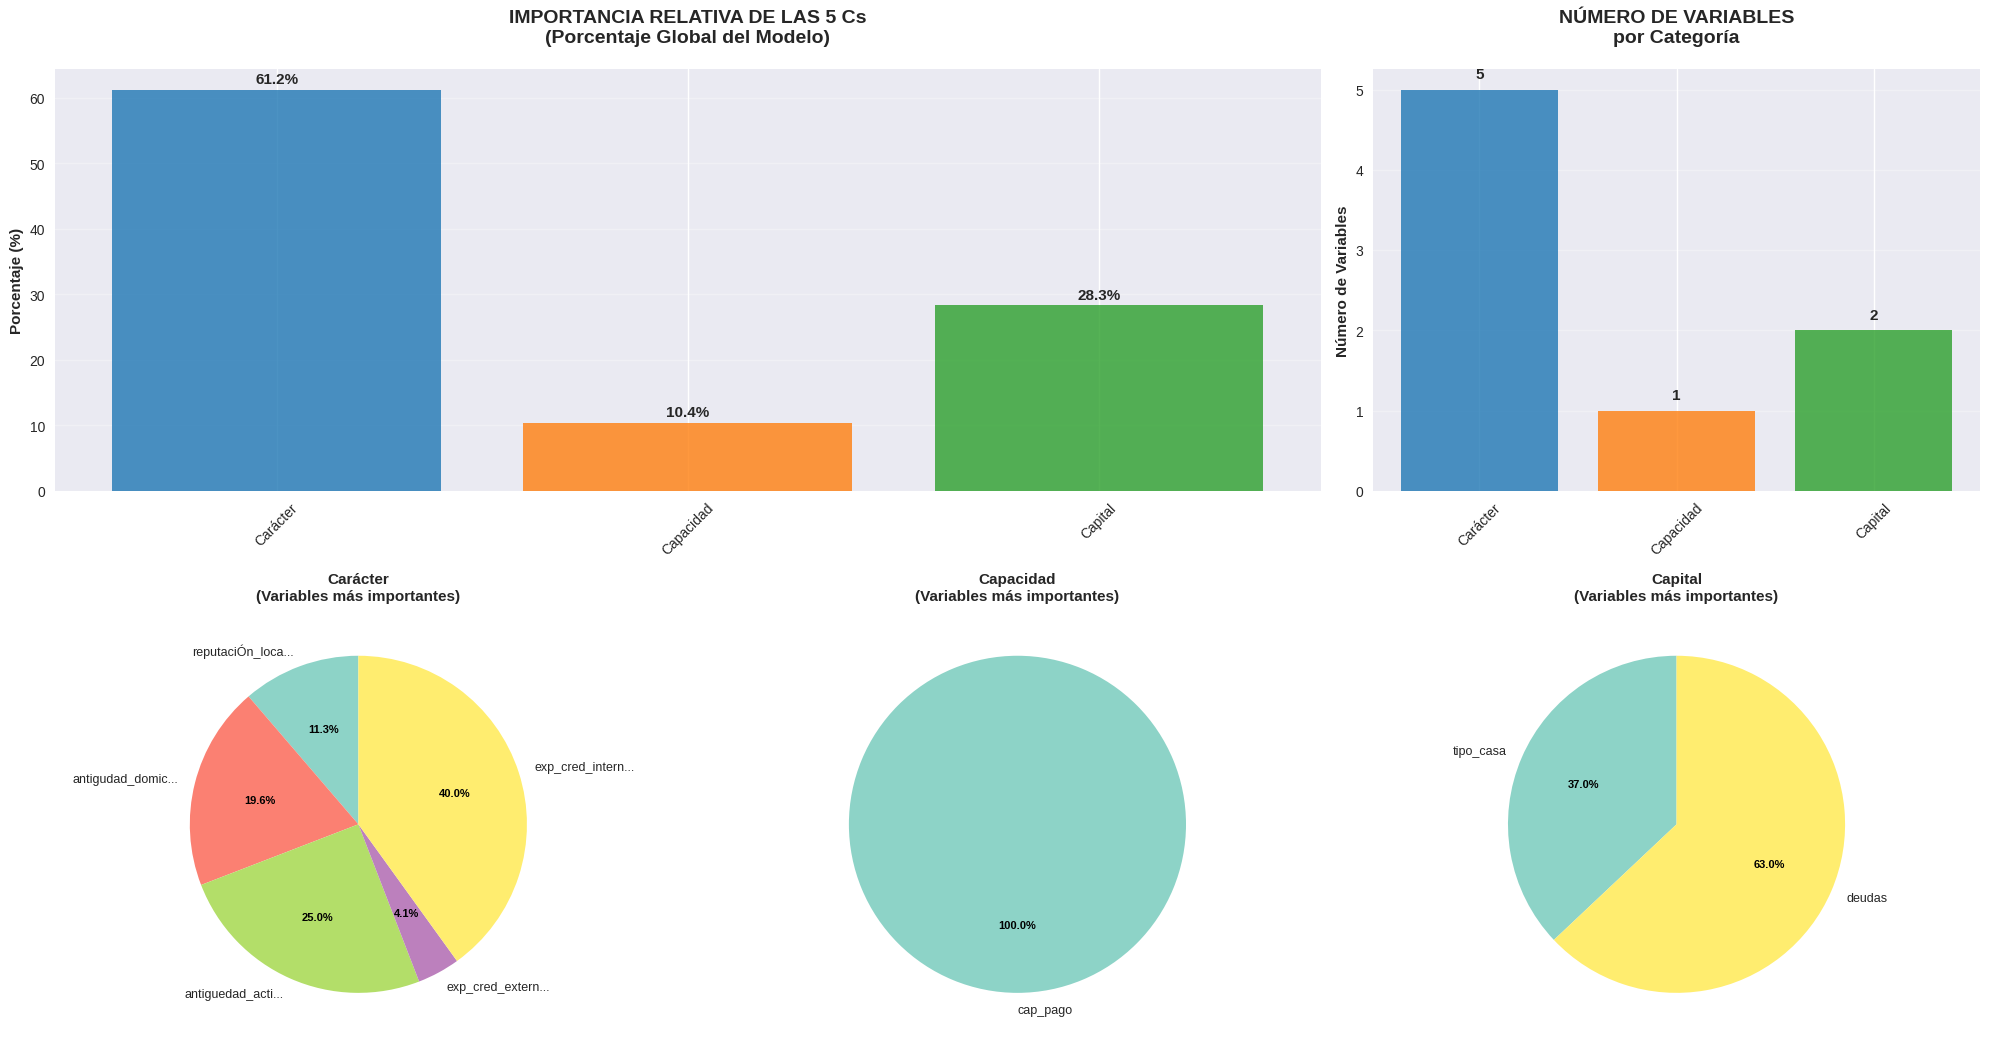


📋 RESUMEN DETALLADO POR VARIABLE

🔍 CARÁCTER (61.2% del total)
--------------------------------------------------------------------------------
  ⭐⭐ exp_cred_interna:
     📊 Importancia: 0.020603
     📈 Porcentaje dentro de Carácter: 40.0%
     🔢 Características: 3
     🎯 Features principales: exp_cred_interna_HASTA 5 ATRASOS DE 8 A 15 DIAS (CALIF. C), exp_cred_interna_HASTA 5 ATRASOS MENORES DE 7 DIAS(CALIF. B), exp_cred_interna_PAGO PUNTUAL(CALIF. A)

  ⭐ antiguedad_actividad:
     📊 Importancia: 0.012868
     📈 Porcentaje dentro de Carácter: 25.0%
     🔢 Características: 3
     🎯 Features principales: antiguedad_actividad_MAYOR DE 5 AÑOS, antiguedad_actividad_DE 3 A 5 AÑOS, antiguedad_actividad_MENOR A 1 AÑO

  ⭐ antigudad_domicilio:
     📊 Importancia: 0.010066
     📈 Porcentaje dentro de Carácter: 19.6%
     🔢 Características: 3
     🎯 Features principales: antigudad_domicilio_MAYOR DE 5 AÑOS, antigudad_domicilio_DE 4 A 5 AÑOS, antigudad_domicilio_MENOR DE 1 AÑO

  ⭐ reputaciÓn_l

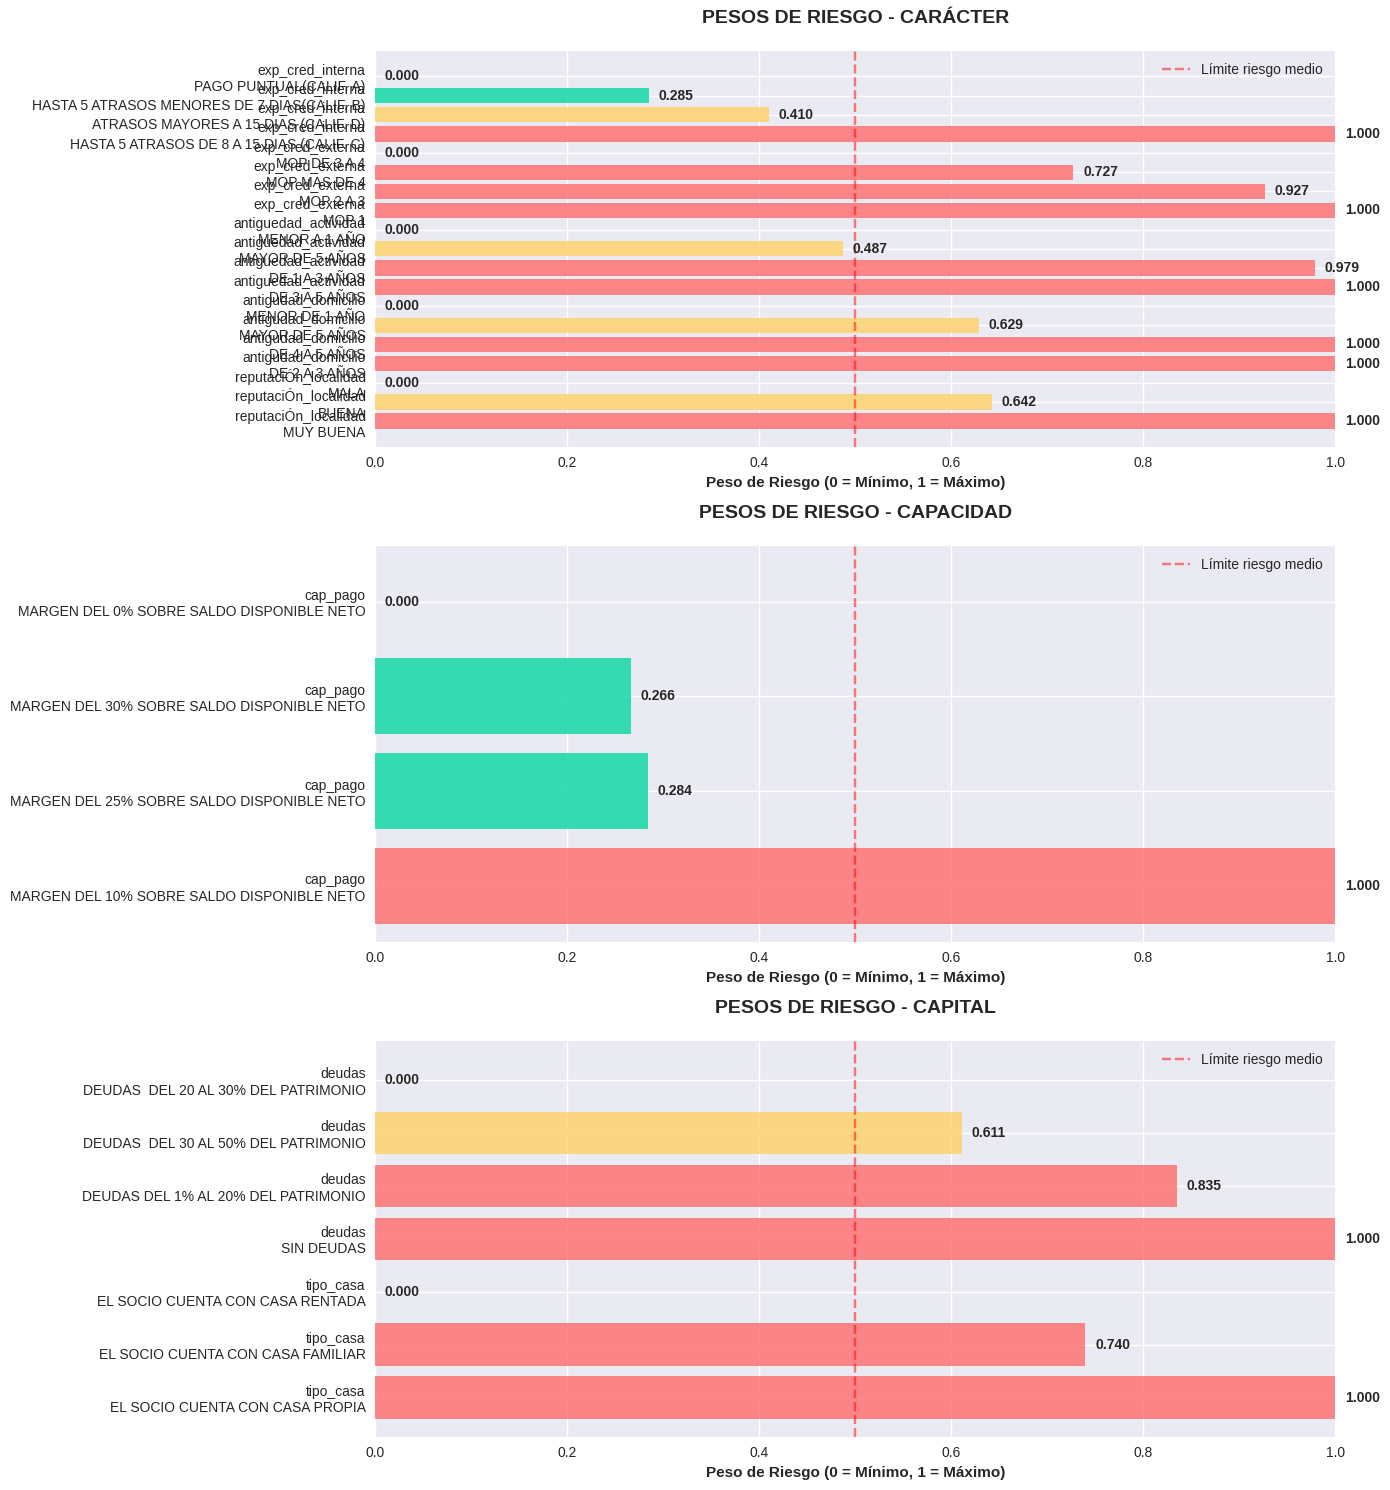

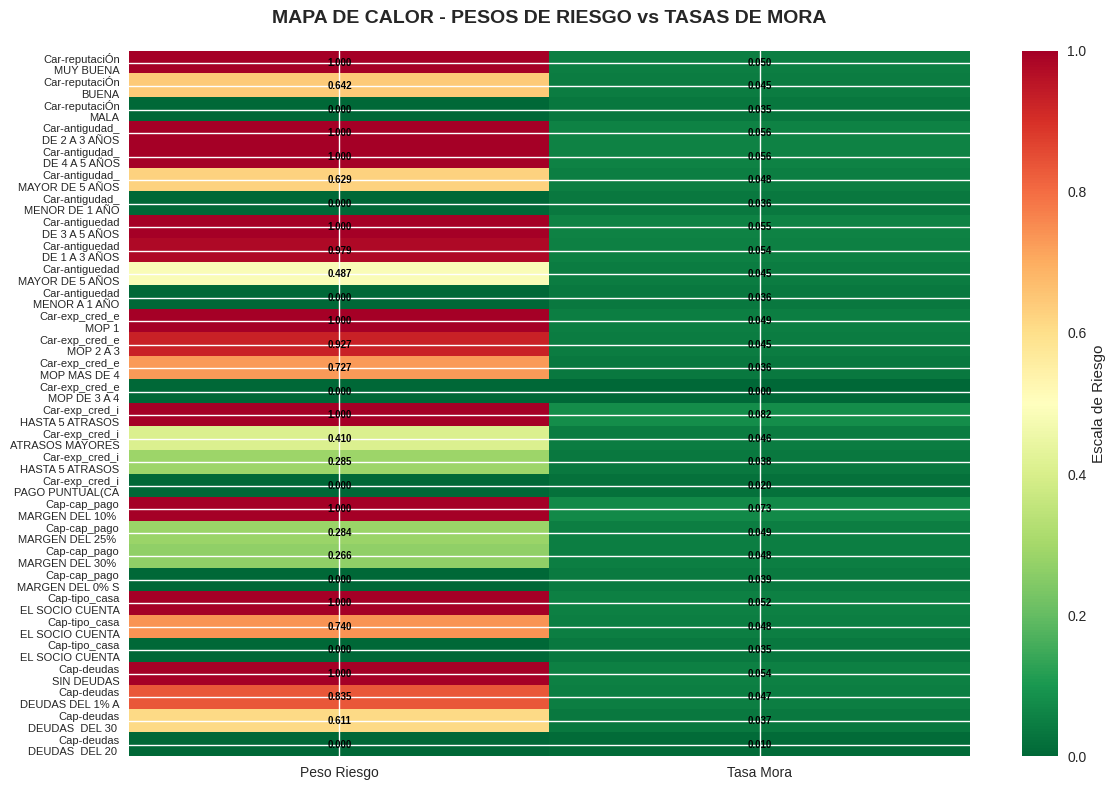


💾 Exportando resultados a analisis_5cs_completo.xlsx...
✅ Exportación completada con éxito.

💾 Exportando pesos detallados a pesos_detallados_5cs.xlsx...
✅ Pesos detallados exportados exitosamente a: pesos_detallados_5cs.xlsx

🎯 RESUMEN EJECUTIVO COMPLETO
📊 Categoría más importante: Carácter (61.2%)
⭐ Variable más importante: exp_cred_interna (Carácter)

⚠️  VALORES MÁS RIESGOSOS POR CATEGORÍA:
   🔴 Carácter - reputaciÓn_localidad: 'MUY BUENA' (Peso: 1.000, Tasa: 5.0%)
   🔴 Carácter - antigudad_domicilio: 'DE 2 A 3 AÑOS' (Peso: 1.000, Tasa: 5.6%)
   🔴 Carácter - antiguedad_actividad: 'DE 3 A 5 AÑOS' (Peso: 1.000, Tasa: 5.5%)
   🔴 Carácter - exp_cred_externa: 'MOP 1' (Peso: 1.000, Tasa: 4.9%)
   🔴 Carácter - exp_cred_interna: 'HASTA 5 ATRASOS DE 8 A 15 DIAS (CALIF. C)' (Peso: 1.000, Tasa: 8.2%)
   🔴 Capacidad - cap_pago: 'MARGEN DEL 10% SOBRE SALDO DISPONIBLE NETO' (Peso: 1.000, Tasa: 7.3%)
   🔴 Capital - tipo_casa: 'EL SOCIO CUENTA CON CASA PROPIA' (Peso: 1.000, Tasa: 5.2%)
   🔴 Capit

In [39]:
# Cargar tus datos (asegúrate de que df esté definido)
df = LeerBaseDatos()  # Descomenta si necesitas cargar los datos
parametrizacion = any
# Ejecutar análisis completo
try:
    #df_enhanced, resultados, feature_importance = analisis_completo_5cs(df)
    df_enhanced, resultados, feature_importance = analisis_completo_5cs_con_pesos(df)
    # 1. Generas la parametrización desde tu dataset histórico
    parametrizacion = generar_parametrizacion_scoring(df)
    # 2. Nuevo socio (registro en forma de dict)
    nuevo = {
        "reputaciÓn_localidad": "BUENA",
        "antigudad_domicilio": "3-5 AÑOS",
        "antiguedad_actividad": "1-3 AÑOS",
        "exp_cred_externa": "NINGUNA",
        "exp_cred_interna": "BUENA",
        "cap_pago": "ADECUADA",
        "tipo_casa": "PROPIA",
        "deudas": "BAJAS"
    }

    # 3. Calcular score
    score_total, detalle = calcular_scoring_nuevo_registro(nuevo, parametrizacion)

    print("Score total:", score_total)
    print("Detalle:", detalle)

    # 4. Autorizar
    #decision = autorizar_socio(score_total)
    #print("Decisión:", decision)

    print("\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
except Exception as e:
    print(f"❌ Error en el análisis: {e}")
    print("💡 Asegúrate de que el DataFrame 'df' esté cargado correctamente")

In [36]:
# Cargar tus datos (asegúrate de que df esté definido)
df = LeerBaseDatos()  # Descomenta si necesitas cargar los datos
# Ejecutar análisis completo
try:
    #df_enhanced, resultados, feature_importance = analisis_completo_5cs(df)
    #df_enhanced, resultados, feature_importance = analisis_completo_5cs_con_pesos(df)
    sistema, pesos, ejemplo = analisis_completo_con_scoring(df)
    
    print("\n✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
except Exception as e:
    print(f"❌ Error en el análisis: {e}")
    print("💡 Asegúrate de que el DataFrame 'df' esté cargado correctamente")

🚀 INICIANDO ANÁLISIS COMPLETO CON SISTEMA DE SCORING
🔧 Aplicando Feature Engineering para riesgo crediticio...
   - Creando ratios financieros...
   - Creando scores de historial crediticio...
   - Creando variables de estabilidad...
   - Calculando scores compuestos...
✅ Feature engineering completado
   Nuevas variables creadas: 16

🎯 CREANDO SISTEMA DE SCORING NUMÉRICO

📊 Carácter:
----------------------------------------
  🔸 reputaciÓn_localidad:
     🟢 BAJO 'MALA':
        🎯 Puntaje: 100.0 pts
        📈 Tasa mora: 3.5%
        📊 Casos: 2290.0
     🔴 ALTO 'BUENA':
        🎯 Puntaje: 27.0 pts
        📈 Tasa mora: 4.5%
        📊 Casos: 471.0
     🔴 ALTO 'MUY BUENA':
        🎯 Puntaje: 0.0 pts
        📈 Tasa mora: 5.0%
        📊 Casos: 11790.0
        ⚖️  Peso variable: 0.151

  🔸 antigudad_domicilio:
     🟢 BAJO 'MENOR DE 1 AÑO':
        🎯 Puntaje: 100.0 pts
        📈 Tasa mora: 3.6%
        📊 Casos: 1743.0
     🔴 ALTO 'MAYOR DE 5 AÑOS':
        🎯 Puntaje: 28.0 pts
        📈 Tasa mor

In [27]:
pesos

{'Carácter': {'reputaciÓn_localidad': np.float64(0.15100000000000002),
  'antigudad_domicilio': np.float64(0.202),
  'antiguedad_actividad': np.float64(0.191),
  'exp_cred_externa': np.float64(0.491),
  'exp_cred_interna': np.float64(0.617)},
 'Capacidad': {'cap_pago': np.float64(0.338)},
 'Capital': {'tipo_casa': np.float64(0.16899999999999998),
  'deudas': np.float64(0.44200000000000006)}}

In [37]:
ejemplo_socio = df_enhanced.iloc[0].to_dict()
resultado_scoring = calcular_score_socio(sistema, pesos, ejemplo_socio)



🧮 CALCULANDO SCORE PARA SOCIO:
----------------------------------------
📊 Carácter:
   🟢 reputaciÓn_localidad: 'MALA' = 100 pts × 0.15 = 15.1 pts
   🟢 antigudad_domicilio: 'MENOR DE 1 AÑO' = 100 pts × 0.20 = 20.2 pts
   🟢 antiguedad_actividad: 'MENOR A 1 AÑO' = 100 pts × 0.19 = 19.1 pts
   🔴 exp_cred_externa: 'MOP MAS DE 4' = 20 pts × 0.49 = 9.8 pts
   🟡 exp_cred_interna: 'ATRASOS MAYORES A 15 DIAS (CALIF. D)' = 46 pts × 0.62 = 28.4 pts
92.602           -----          165.2
165.2           -----          92.602
   📈 Score Carácter: 92.6/165.2 (56.1%)
📊 Capacidad:
   🟢 cap_pago: 'MARGEN DEL 0% SOBRE SALDO DISPONIBLE NETO' = 100 pts × 0.34 = 33.8 pts
126.40200000000002           -----          199.0
33.800000000000004           -----          33.800000000000004
   📈 Score Capacidad: 33.8/33.8 (100.0%)
📊 Capital:
   🟢 tipo_casa: 'EL SOCIO CUENTA CON CASA RENTADA' = 100 pts × 0.17 = 16.9 pts
   🔴 deudas: 'DEUDAS  DEL 30 AL 50% DEL PATRIMONIO' = 29 pts × 0.44 = 12.8 pts
156.12           --